# Prediction of number of days an animal (dog-cat) will spend in the shelter before being addopted.

# Table of Contents
1. [Data cleaning and preparation](#1.-Data-cleaning-and-preparation)

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from collections import Counter
from itertools import combinations
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score



In [2]:
# read prepared dataset
df = pd.DataFrame(pd.read_csv('data.csv'))

## 1. Data cleaning and preparation

Dataframe from source

In [3]:
df.head().T

,0,1,2,3,4
animal_id,A844350,A818975,A760053,A707375,A696408
name,*Ella,NaN,NaN,*Candy Cane,*Pearl
datetime_intake,2021-10-15 11:40:00,2020-06-18 14:53:00,2017-10-11 15:46:00,2015-07-11 18:19:00,2015-02-04 12:58:00
found_location,2112 East William Cannon Drive in Austin (TX),Braker Lane And Metric in Travis (TX),8800 South First Street in Austin (TX),Galilee Court And Damita Jo Dr in Manor (TX),9705 Thaxton in Austin (TX)
intake_type,Stray,Stray,Stray,Stray,Stray
intake_condition,Normal,Normal,Normal,Normal,Normal
animal_type,Cat,Cat,Dog,Dog,Dog
sex_upon_intake,Intact Female,Intact Male,Intact Male,Intact Female,Intact Female
age_upon_intake,6 months,4 weeks,2 years,5 months,2 years
breed,Domestic Shorthair,Domestic Shorthair,Chihuahua Shorthair,Pit Bull,Chihuahua Shorthair


In [4]:
df.dtypes


animal_id           object
name                object
datetime_intake     object
found_location      object
intake_type         object
intake_condition    object
animal_type         object
sex_upon_intake     object
age_upon_intake     object
breed               object
color               object
datetime_outcome    object
outcome_type        object
dtype: object

#### 1.1 Data types & formats inside df

In [5]:
# datetime columns: datetime_intake, datetime_outcome
datetime_columns = ['datetime_intake', 'datetime_outcome']
# convert the datetime columns to datetime type
for column in datetime_columns:
    df[column] = pd.to_datetime(df[column])
datetime_columns

['datetime_intake', 'datetime_outcome']

In [6]:
# rest of the columns from dataframe that are not datetime categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
categorical_columns

for column in categorical_columns:
    df[column] = df[column].str.lower()

#### 1.2 Target outcome calculation: days in the shelter.

In [7]:
# lets calculate our target variable
# the target variable is the difference between the datetime_outcome and datetime_intake
df['days_in_shelter'] = (df['datetime_outcome'] - df['datetime_intake']).dt.days

#### 1.3 Feature transformation: Clean categories with a lot of unique values

In [8]:
for column in categorical_columns:
    print(f'{column}: {df[column].nunique()} unique values')
    

animal_id: 72209 unique values
name: 19337 unique values
found_location: 32015 unique values
intake_type: 5 unique values
intake_condition: 14 unique values
animal_type: 2 unique values
sex_upon_intake: 5 unique values
age_upon_intake: 47 unique values
breed: 2066 unique values
color: 475 unique values
outcome_type: 1 unique values


- Divide the sex upon intake into sex and castrated status

In [9]:
def castrated_status(row):
    if 'neutered' in row or 'spayed' in row:
        return 'yes'
    else:
        return 'no'

def sex_upon_intake(row):
    if 'female' in row:
        return 'female'
    elif 'male' in row:
        return 'male'
    else:
        return 'unknown'

df['castrated'] = df['sex_upon_intake'].apply(castrated_status)
df['sex_upon_intake'] = df['sex_upon_intake'].apply(sex_upon_intake) 


- Convert age_upon_intake in months 

In [10]:
df.age_upon_intake.value_counts().head()

age_upon_intake
1 month     12725
1 year      11595
2 years     10709
2 months     7730
3 years      3702
Name: count, dtype: int64

In [11]:
def convert_to_months(age):
    # Split the age into value and unit
    parts = age.split()
    if len(parts) != 2:  # Handle unexpected formats
        return None
    
    value, unit = int(parts[0]), parts[1].lower()
    
    # Convert the age to months
    if 'year' in unit:
        return value * 12
    elif 'month' in unit:
        return value 
    elif 'week' in unit:
        return value / 4
    elif 'day' in unit:
        return value / 30
    else:
        return None  # Handle unknown units

# Apply the function to the column and create a new column
df['age_in_months'] = df['age_upon_intake'].apply(convert_to_months)

# Check the resulting DataFrame
print(df[['age_upon_intake', 'age_in_months']].head())


  age_upon_intake  age_in_months
0        6 months            6.0
1         4 weeks            1.0
2         2 years           24.0
3        5 months            5.0
4         2 years           24.0


In [12]:
print(df['age_in_months'].describe())


count    79570.000000
mean        18.051550
std         27.911971
min        -48.000000
25%          1.000000
50%          7.000000
75%         24.000000
max        240.000000
Name: age_in_months, dtype: float64


we can see animals with ages below 0. Lets look at them

In [13]:
df[df['age_in_months']<0]   


,animal_id,name,datetime_intake,found_location,intake_type,intake_condition,animal_type,sex_upon_intake,age_upon_intake,breed,color,datetime_outcome,outcome_type,days_in_shelter,castrated,age_in_months
4384,a725472,rascal,2019-02-26 11:25:00,austin (tx),owner surrender,normal,dog,male,-1 years,chihuahua shorthair mix,white/brown,2019-02-26 14:34:00,adoption,0,yes,-12.0
12699,a725472,rascal,2016-06-12 14:16:00,austin (tx),owner surrender,aged,dog,male,-3 years,chihuahua shorthair mix,white/brown,2016-07-24 15:54:00,adoption,42,yes,-36.0
20142,a783723,pina,2018-11-05 11:00:00,3108 crownover street in austin (tx),stray,normal,cat,female,-4 years,domestic shorthair,white/orange,2018-11-12 11:53:00,adoption,7,no,-48.0


as I assume there are errors, I will remove the -

In [14]:
# remove from age the ¨-¨ character
df['age_in_months'] = df['age_in_months'].abs()

In [15]:
df['age_in_months'].describe()

count    79570.000000
mean        18.053963
std         27.910410
min          0.000000
25%          1.000000
50%          7.000000
75%         24.000000
max        240.000000
Name: age_in_months, dtype: float64

* Breed

In [16]:
df['breed'].value_counts().head()

breed
domestic shorthair mix     15460
domestic shorthair         12496
labrador retriever mix      4726
pit bull mix                4230
chihuahua shorthair mix     3279
Name: count, dtype: int64

In [17]:
# Split the breed column into individual words
all_words = df['breed'].str.split(expand=True).stack()
word_counts = Counter(all_words)
 
word_freq_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)
percentage_limit = 80 # I decided to use 80% as the limit to cover the most important words
total_words = word_freq_df['Frequency'].sum()
word_freq_df['Percentage'] = (word_freq_df['Frequency'] / total_words) * 100
word_freq_df = word_freq_df.sort_values(by='Percentage', ascending=False)
word_freq_df['Cumulative Percentage'] = word_freq_df['Percentage'].cumsum()
important_words_df = word_freq_df[word_freq_df['Cumulative Percentage'] <= percentage_limit]
 
print(f"Important Words in Breeds (% {percentage_limit} Cumulative Importance):")
print(important_words_df)


Important Words in Breeds (% 80 Cumulative Importance):
          Word  Frequency  Percentage  Cumulative Percentage
5          mix      48313   22.501618              22.501618
1    shorthair      32965   15.353339              37.854957
0     domestic      32106   14.953262              52.808219
11   retriever       7250    3.376663              56.184883
12    labrador       7214    3.359896              59.544779
4         bull       6830    3.181050              62.725829
3          pit       6587    3.067873              65.793702
2    chihuahua       5232    2.436787              68.230489
29    shepherd       5003    2.330131              70.560619
28      german       3970    1.849014              72.409634
15     terrier       3393    1.580278              73.989912
39        hair       2937    1.367898              75.357810
8   australian       2853    1.328775              76.686585
38      medium       2846    1.325515              78.012100
9       cattle       2183    

In the table above we can see the words inside breeds that appears in 80% of the records.  
There are somo common properties that would be separated creating more features: 
* extract the hairtype in another column
* separate the mix as separate propertie
* separate miniature
* separate domestic

In [18]:
# 'hair_type'
df['hair_type'] = df['breed'].apply(
    lambda x: 'long' if 'longhair' in x else 'shorthair' if 'shorthair' in x
      else 'medium' if 'medium hair' in x else 'unknown')

df['hair_type'].value_counts()


hair_type
unknown      41214
shorthair    33623
medium        2846
long          1887
Name: count, dtype: int64

In [19]:
# mix breed column
df['mix_breed'] = df['breed'].apply(lambda x: True if 'mix' in x else False)

In [20]:
# miniature breed column
df['miniature'] = df['breed'].apply(lambda x: True if 'miniature' in x else False)

In [21]:
# domestic breed column
df['domestic'] = df['breed'].apply(lambda x: True if 'domestic' in x else False)

After creating these features, let's remove these wordsd from the breed column

In [22]:
words_to_remove = ['mix', 'shorthair', 'longhair', 'medium hair', 'miniature', 'domestic','dog','cat']
for word in words_to_remove:
    df['breed'] = df['breed'].str.replace(word, '').str.strip()

Get the pair combinations of names inside breed so as to identify common ones.

In [23]:
# Tokenize each row in the breed column
df['breed_tokenized'] = df['breed'].str.split()
word_pairs = df['breed_tokenized'].apply(lambda x: list(combinations(x, 2)))

all_pairs = [pair for pairs in word_pairs for pair in pairs]

pair_counts = Counter(all_pairs)
pair_freq_df = pd.DataFrame(pair_counts.items(), columns=['Pair', 'Frequency']).sort_values(by='Frequency', ascending=False)
total_pairs = pair_freq_df['Frequency'].sum()
pair_freq_df['Percentage'] = (pair_freq_df['Frequency'] / total_pairs) * 100
pair_freq_df['Cumulative Percentage'] = pair_freq_df['Percentage'].cumsum()

target_percentage = 0.8  # I decided to use 80% as the limit to cover the most important pairs
frequent_pairs_df = pair_freq_df[pair_freq_df['Percentage'] >= target_percentage]
print("Frequent Word Pairs with Running Percentage:")
print(frequent_pairs_df)

Frequent Word Pairs with Running Percentage:
                       Pair  Frequency  Percentage  Cumulative Percentage
0               (pit, bull)       6201   11.665444              11.665444
8     (labrador, retriever)       5738   10.794439              22.459883
17       (german, shepherd)       3246    6.106439              28.566322
2         (australian, tle)       1824    3.431345              31.997667
12        (siberian, husky)        946    1.779634              33.777301
62         (border, collie)        754    1.418440              35.195741
24         (american, bull)        695    1.307448              36.503189
54   (australian, shepherd)        600    1.128732              37.631921
21        (great, pyrenees)        589    1.108038              38.739959
97          (jack, russell)        555    1.044077              39.784036
99       (russell, terrier)        534    1.004571              40.788607
25      (american, terrier)        492    0.925560              41.

Assign the most frequent combinations to a new property called breed_group1

In [24]:
# Ensure the breed column and frequent pairs are processed correctly
def assign_breed_group(breed, frequent_pairs):
    for pair in frequent_pairs:
        if all(word in breed for word in pair):
            return f"{pair[0]}_{pair[1]}"
    return None

# Apply the function to the DataFrame
df['breed_group1'] = df['breed'].apply(lambda x: assign_breed_group(x, frequent_pairs_df['Pair'].tolist()))
df['breed_group1'].value_counts()

breed_group1
labrador_retriever     8087
pit_bull               7135
german_shepherd        3996
australian_tle         1851
siberian_husky         1041
border_collie           972
great_pyrenees          708
australian_shepherd     612
jack_russell            592
black_mouth             477
american_bull           395
american_terrier        204
russell_terrier          29
Name: count, dtype: int64

After checking the combinations, lets see which repeated words remain there (removing the combinations from the breed before)

In [25]:
top_combinations = frequent_pairs_df['Pair'].tolist()

def remove_combinations(breed, combinations):
    for pair in combinations:
        if all(word in breed for word in pair):
            breed = breed.replace(f"{pair[0]} {pair[1]}", "")
    return breed.strip()

# Apply the function to clean up the breed column
df['breed'] = df['breed'].apply(lambda x: remove_combinations(x, top_combinations))

# after cleaning the breed column, we can re-calculate the frequent words
df_no_breed_group = df[df['breed_group1'].isna()]

all_words = df_no_breed_group['breed'].str.split(expand=True).stack()
word_counts = Counter(all_words)


word_freq_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)
percentage_limit = 2 # I decided to use 2% as the limit to cover the most important words
total_words = word_freq_df['Frequency'].sum()
word_freq_df['Percentage'] = (word_freq_df['Frequency'] / total_words) * 100
word_freq_df = word_freq_df.sort_values(by='Percentage', ascending=False)
word_freq_df['Cumulative Percentage'] = word_freq_df['Percentage'].cumsum()
frequent_words_df = word_freq_df[word_freq_df['Percentage'] >= percentage_limit]

# Print the resulting DataFrame
print(f"Frequent Words in Breeds (% {percentage_limit}  Importance):")
print(frequent_words_df)

Frequent Words in Breeds (% 2  Importance):
         Word  Frequency  Percentage  Cumulative Percentage
0   chihuahua       5170   16.182040              16.182040
5     terrier       2292    7.173933              23.355974
38    siamese       1034    3.236408              26.592382
34  dachshund        904    2.829510              29.421891
76      hound        804    2.516511              31.938402
11     poodle        704    2.203512              34.141914
54      boxer        693    2.169082              36.310996


These are the most relevant words in breeds that have more than 2% of the records.

In [26]:
exclude_words = ['bull', 'pit'] 
frequent_words_df = frequent_words_df[~frequent_words_df['Word'].isin(exclude_words)]

Assign the most repeated words as breed_group2

In [27]:
# Ensure the breed column and frequent pairs are processed correctly
def assign_breed_word(breed, frequent_words):
    for word in frequent_words:
        if word in breed:
            return word
    return None
# Apply the function to the DataFrame
df['breed_group2'] = df['breed'].apply(lambda x: assign_breed_word(x, frequent_words_df['Word'].tolist()))

df['breed_group2'].value_counts()

breed_group2
chihuahua    5908
terrier      3478
hound        1439
dachshund    1112
boxer        1101
siamese      1054
poodle        725
Name: count, dtype: int64

Merge breed_group1 & breed_group2 (using coalesce and prioritizing the combinations)

In [28]:
df['breed_group'] = df['breed_group1'].fillna(df['breed_group2'])

# assign the breed_group to other if it is still null
df['breed_group'] = df['breed_group'].fillna('Other')

* Color

In [29]:
color_combinations = df['color'].str.split('/') # Split the color column by '/'
split_colors = color_combinations.apply(lambda x: [part.split()[0] for part in x] if isinstance(x, list) else []) # get the first word of each component

df['color_primary'] = split_colors.apply(lambda x: x[0] if len(x) > 0 else None)  # First color
df['color_secondary'] = split_colors.apply(lambda x: x[1] if len(x) > 1 else None)  # Second color

# single-color groups
single_colors = df[df['color_secondary'].isnull()]['color_primary'] # get single-color records

percentage_limit  = 0.05
single_color_counts = single_colors.value_counts()
total_single = single_colors.count()
dominant_single_colors = single_color_counts[single_color_counts / total_single >percentage_limit].index

df['single_color_group'] = df['color_primary'].apply(
    lambda x: x if x in dominant_single_colors else 'other_single_colour'
) 

# two-color combinations
df['sorted_combination'] = df.apply(
    lambda row: tuple(sorted([row['color_primary'], row['color_secondary']]))
    if pd.notnull(row['color_secondary']) else None,
    axis=1
)

percentage_limit_combinations = 0.05
combination_counts = df['sorted_combination'].dropna().value_counts()
total_combinations = combination_counts.sum()
dominant_combinations = combination_counts[combination_counts / total_combinations > percentage_limit_combinations].index

df['combination_group'] = df['sorted_combination'].apply(
    lambda x: x if x in dominant_combinations else 'other_multiple_color'
) 

# final color group assignment
df['color_group'] = df.apply(
    lambda row: row['single_color_group']
    if pd.isnull(row['sorted_combination'])
    else row['combination_group'],
    axis=1
)
df['color_group'] = df['color_group'].apply(
    lambda x: ' & '.join(x) if isinstance(x, tuple) else x  # Convert tuples to readable strings
) 

df['color_group'].value_counts()

color_group
black & white           11421
other_single_colour     11176
other_multiple_color     9784
brown & white            9153
brown                    7718
black                    6702
blue & white             3801
tan & white              3599
black & brown            3446
blue                     3315
black & tan              2713
orange                   2476
white                    2333
tan                      1933
Name: count, dtype: int64

In [30]:
# what is the share of other_single_colour and other_multiple_color in the color_group column?
color_group_counts = df['color_group'].value_counts(normalize=True)
other_single_color_share = color_group_counts['other_single_colour']
other_multiple_color_share = color_group_counts['other_multiple_color']
print(f"Share of 'other_single_colour': {other_single_color_share:.2%}")
print(f"Share of 'other_multiple_color': {other_multiple_color_share:.2%}")

Share of 'other_single_colour': 14.05%
Share of 'other_multiple_color': 12.30%


#### 1.4 Drop unnecessary features

In [31]:
# drop the columns that are not useful 
df = df.drop(['name'], axis=1).reset_index(drop=True)
del df['age_upon_intake']
del df['breed_group1']
del df['breed_group2']
del df['breed']
del df['breed_tokenized']
del df['color']
del df['color_primary']
del df['color_secondary']   
del df['single_color_group']
del df['sorted_combination']
del df['combination_group']


## EDA

1. What is the distribution of the days_in_shelter?

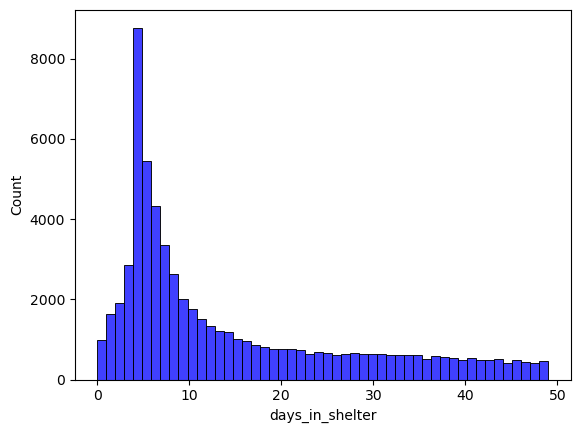

In [32]:
# Filter the data to only include values less than 50
filtered_data = df[df.days_in_shelter < 50]

plot = sns.histplot(filtered_data.days_in_shelter, color="b", kde=False, bins=50)

plt.show()

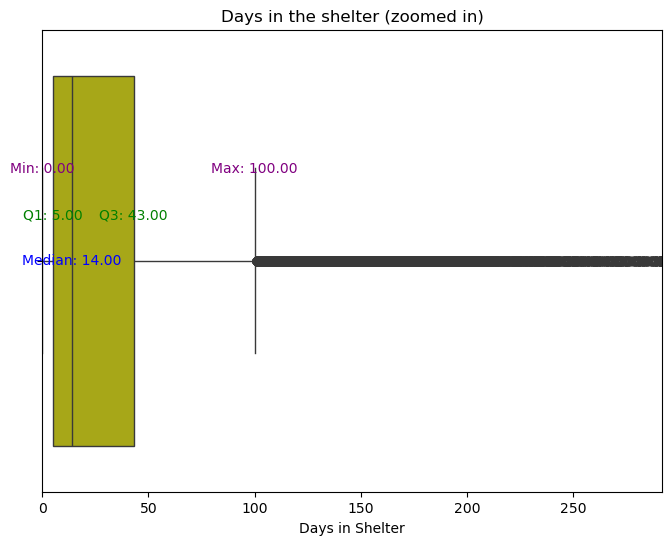

In [33]:
# Calculate key statistics
q1 = df['days_in_shelter'].quantile(0.25)
median = df['days_in_shelter'].median()
q3 = df['days_in_shelter'].quantile(0.75)
iqr = q3 - q1 
min_whisker = max(q1 - 1.5 * iqr, df['days_in_shelter'].min())
max_whisker = min(q3 + 1.5 * iqr, df['days_in_shelter'].max())

plt.figure(figsize=(8, 6))
ax = sns.boxplot(data=df, x='days_in_shelter', color='y')

#  zoom in
plt.xlim(df['days_in_shelter'].quantile(0.01), df['days_in_shelter'].quantile(0.99))


plt.text(median, 0, f'Median: {median:.2f}', ha='center', va='center', fontsize=10, color='blue')
plt.text(q1, -0.1, f'Q1: {q1:.2f}', ha='center', va='center', fontsize=10, color='green')
plt.text(q3, -0.1, f'Q3: {q3:.2f}', ha='center', va='center', fontsize=10, color='green')
plt.text(min_whisker, -0.2, f'Min: {min_whisker:.2f}', ha='center', va='center', fontsize=10, color='purple')
plt.text(max_whisker, -0.2, f'Max: {max_whisker:.2f}', ha='center', va='center', fontsize=10, color='purple')

# Add labels and title
plt.title('Days in the shelter (zoomed in)')
plt.xlabel('Days in Shelter')

# Display the plot
plt.show()


Creation of df just for EDA without outliers

In [34]:
df_eda =df[df.days_in_shelter < df.days_in_shelter.quantile(0.99)]

2. Lets see if the properties we have defined make a difference in the addoption time

In [35]:
df_eda.domestic.value_counts()

domestic
False    46829
True     31942
Name: count, dtype: int64

/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_19495/113301014.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values.round(1), y=value_counts.index, ax=axes[i, 1], palette='viridis')
/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_19495/113301014.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values.round(1), y=value_counts.index, ax=axes[i, 1], palette='viridis')
/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_19495/113301014.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

 

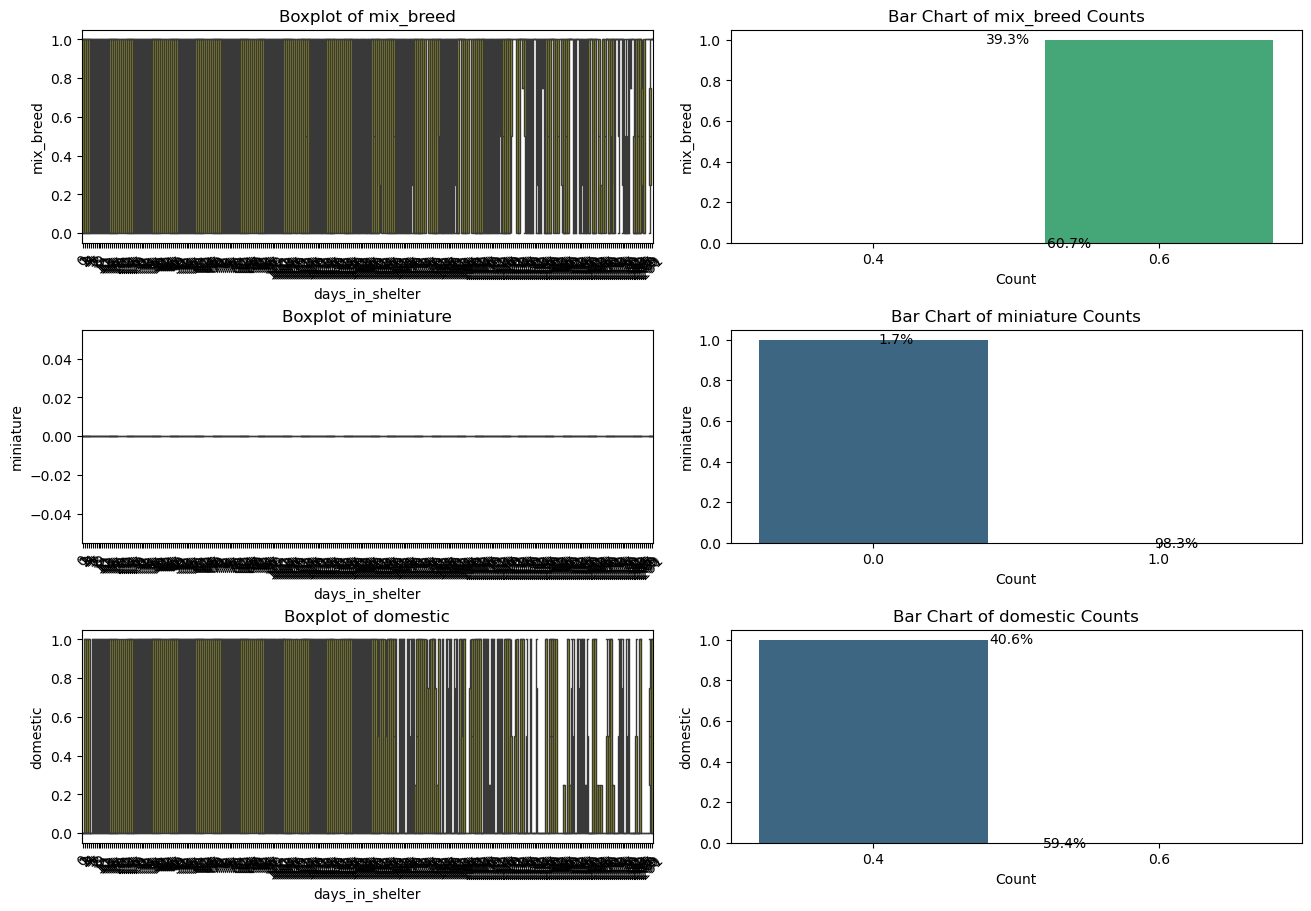

In [36]:
categories_graph = [ 'mix_breed', 'miniature', 
                    'domestic']
 
n_cols = 2  
n_rows = len(categories_graph)  
fig, axes = plt.subplots(n_rows, n_cols, figsize=(13, n_rows * 3), constrained_layout=True)
 
axes = axes.reshape(-1, n_cols) if len(categories_graph) > 1 else [axes]

for i, column in enumerate(categories_graph):
    sns.boxplot(x="days_in_shelter", y=column, data=df_eda, showfliers=False, color='y', ax=axes[i, 0])
    axes[i, 0].set_xticks(axes[i, 0].get_xticks())
    axes[i, 0].tick_params(axis='x', rotation=45)  
    axes[i, 0].set_title(f'Boxplot of {column}')
    
    value_counts = df_eda[column].value_counts(normalize=True)
    sns.barplot(x=value_counts.values.round(1), y=value_counts.index, ax=axes[i, 1], palette='viridis')
    axes[i, 1].set_title(f'Bar Chart of {column} Counts')
    for j, value in enumerate(value_counts.values):
        axes[i, 1].text(value, j, f'{value:.1%}', ha='left', va='center')
    axes[i, 1].set_xlabel('Count')
    axes[i, 1].set_ylabel(column)

plt.show()



/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_19495/3095781530.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values.round(1), y=value_counts.index, ax=axes[i, 1], palette='viridis')
/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_19495/3095781530.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values.round(1), y=value_counts.index, ax=axes[i, 1], palette='viridis')
/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_19495/3095781530.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

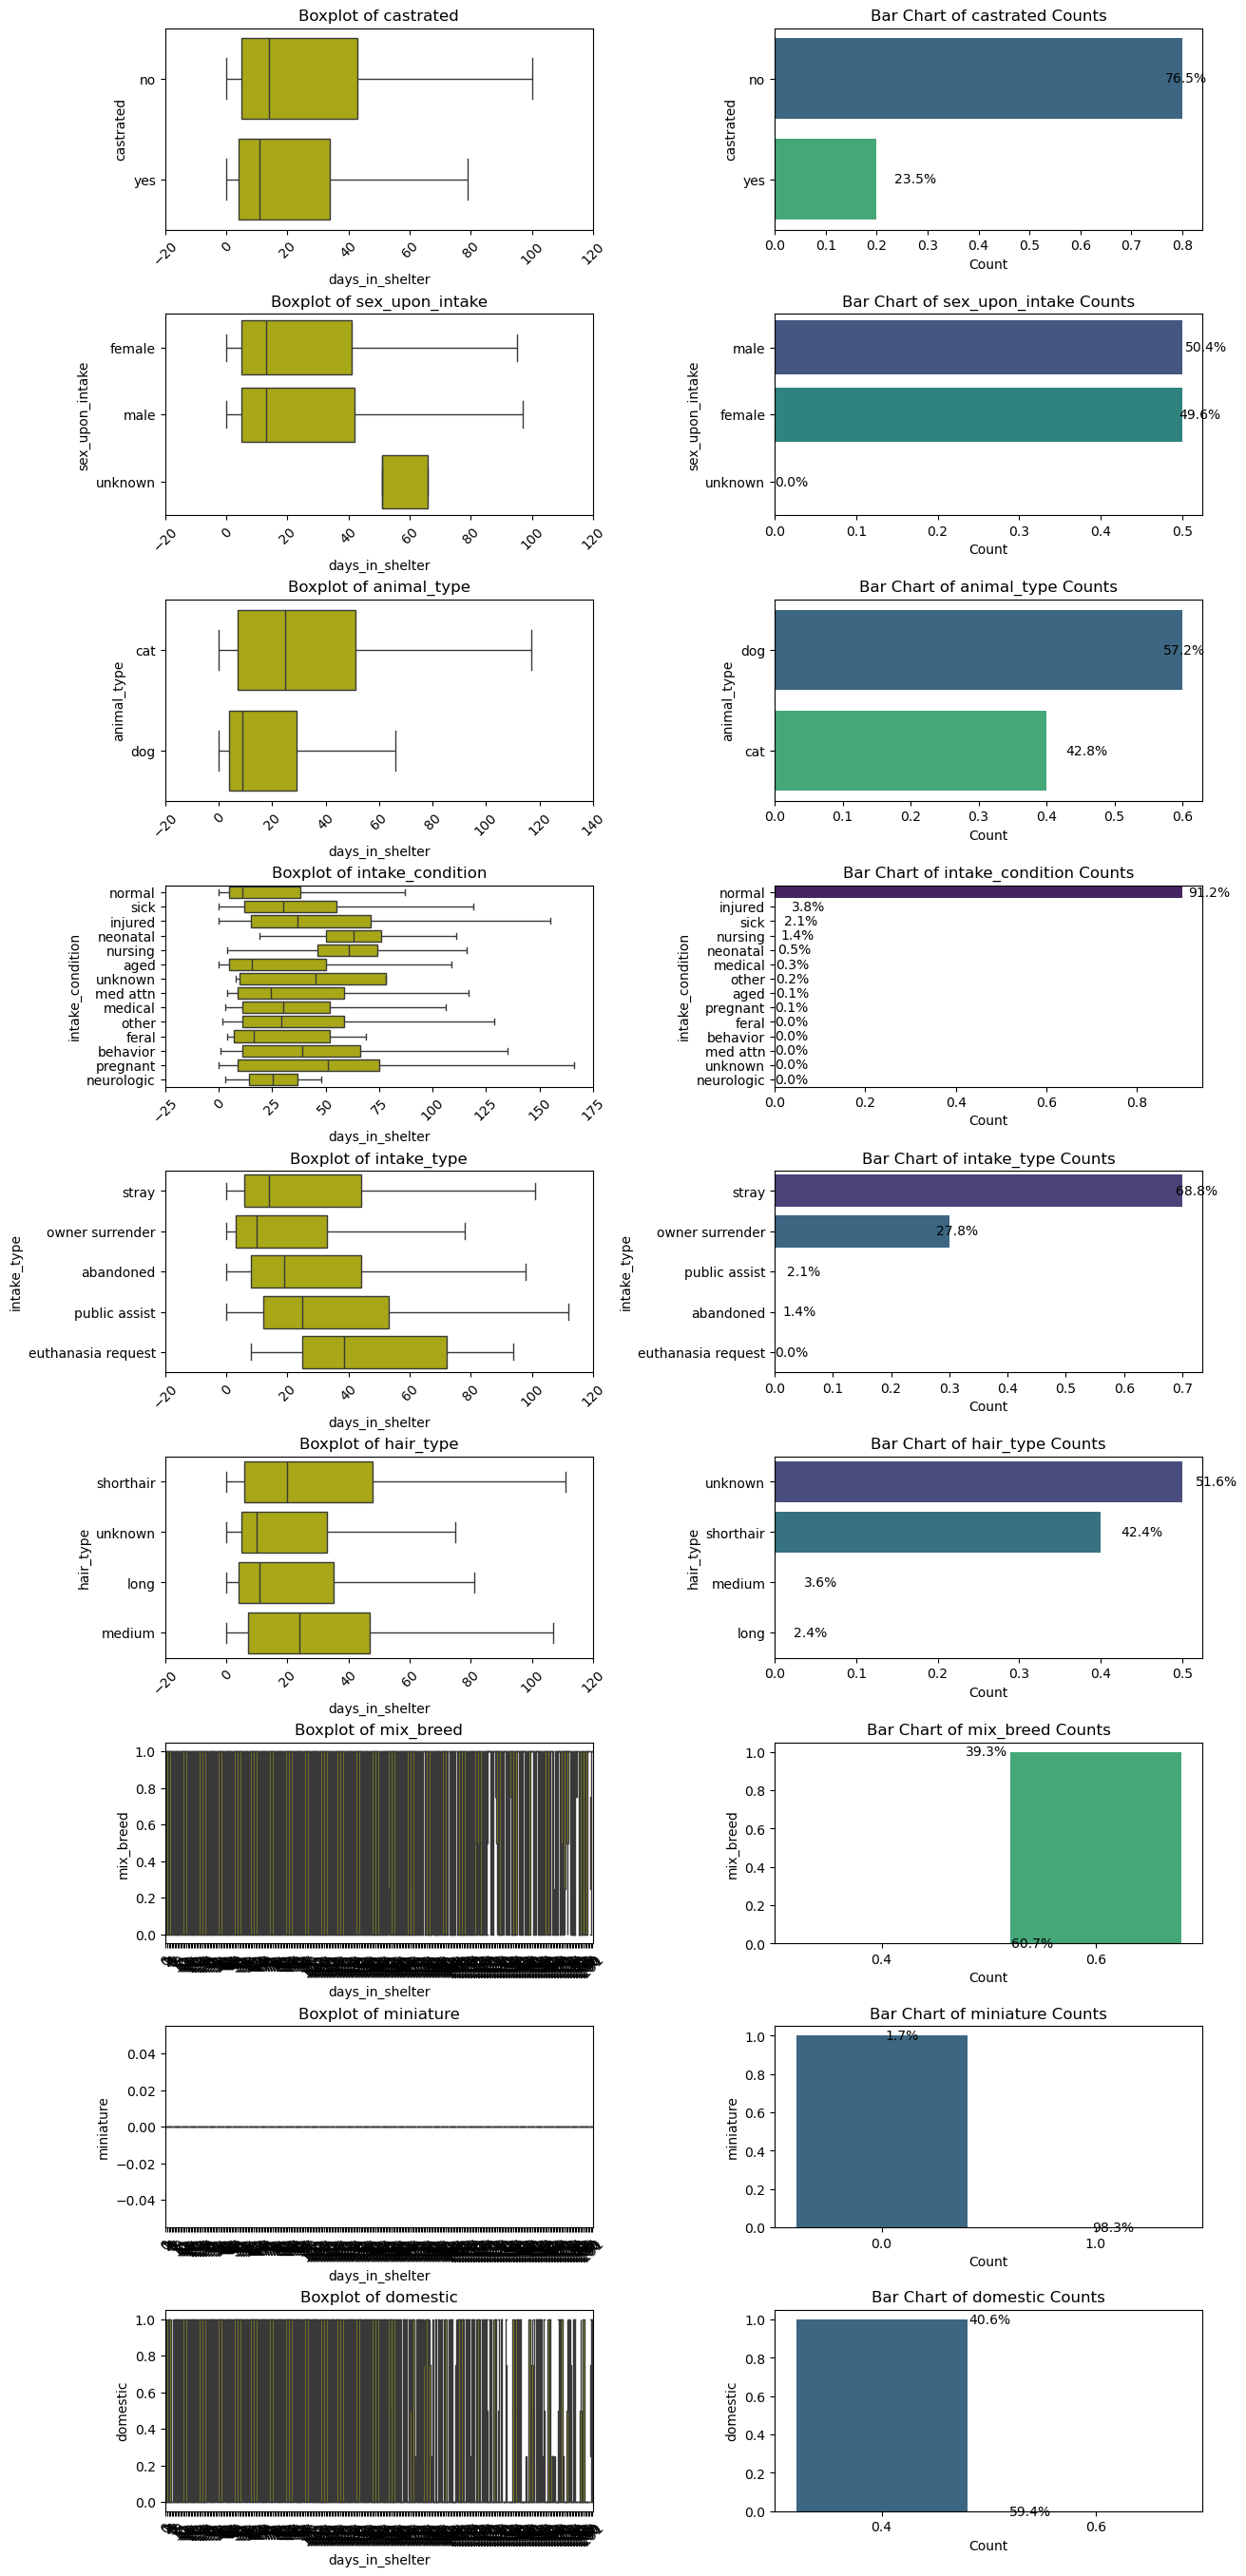

In [37]:
categories_graph = ['castrated', 'sex_upon_intake', 'animal_type', 'intake_condition',
                     'intake_type', 'hair_type', 'mix_breed', 'miniature', 
                    'domestic']
 
n_cols = 2  
n_rows = len(categories_graph)  
fig, axes = plt.subplots(n_rows, n_cols, figsize=(13, n_rows * 3), constrained_layout=True)
 
axes = axes.reshape(-1, n_cols) if len(categories_graph) > 1 else [axes]

for i, column in enumerate(categories_graph):
    sns.boxplot(x="days_in_shelter", y=column, data=df_eda, showfliers=False, color='y', ax=axes[i, 0])
    axes[i, 0].set_xticks(axes[i, 0].get_xticks())
    axes[i, 0].tick_params(axis='x', rotation=45)  
    axes[i, 0].set_title(f'Boxplot of {column}')
    
    value_counts = df_eda[column].value_counts(normalize=True)
    sns.barplot(x=value_counts.values.round(1), y=value_counts.index, ax=axes[i, 1], palette='viridis')
    axes[i, 1].set_title(f'Bar Chart of {column} Counts')
    for j, value in enumerate(value_counts.values):
        axes[i, 1].text(value, j, f'{value:.1%}', ha='left', va='center')
    axes[i, 1].set_xlabel('Count')
    axes[i, 1].set_ylabel(column)

plt.show()



/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_19495/316672360.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index, ax=axes[i, 1], palette='viridis')
/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_19495/316672360.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index, ax=axes[i, 1], palette='viridis')


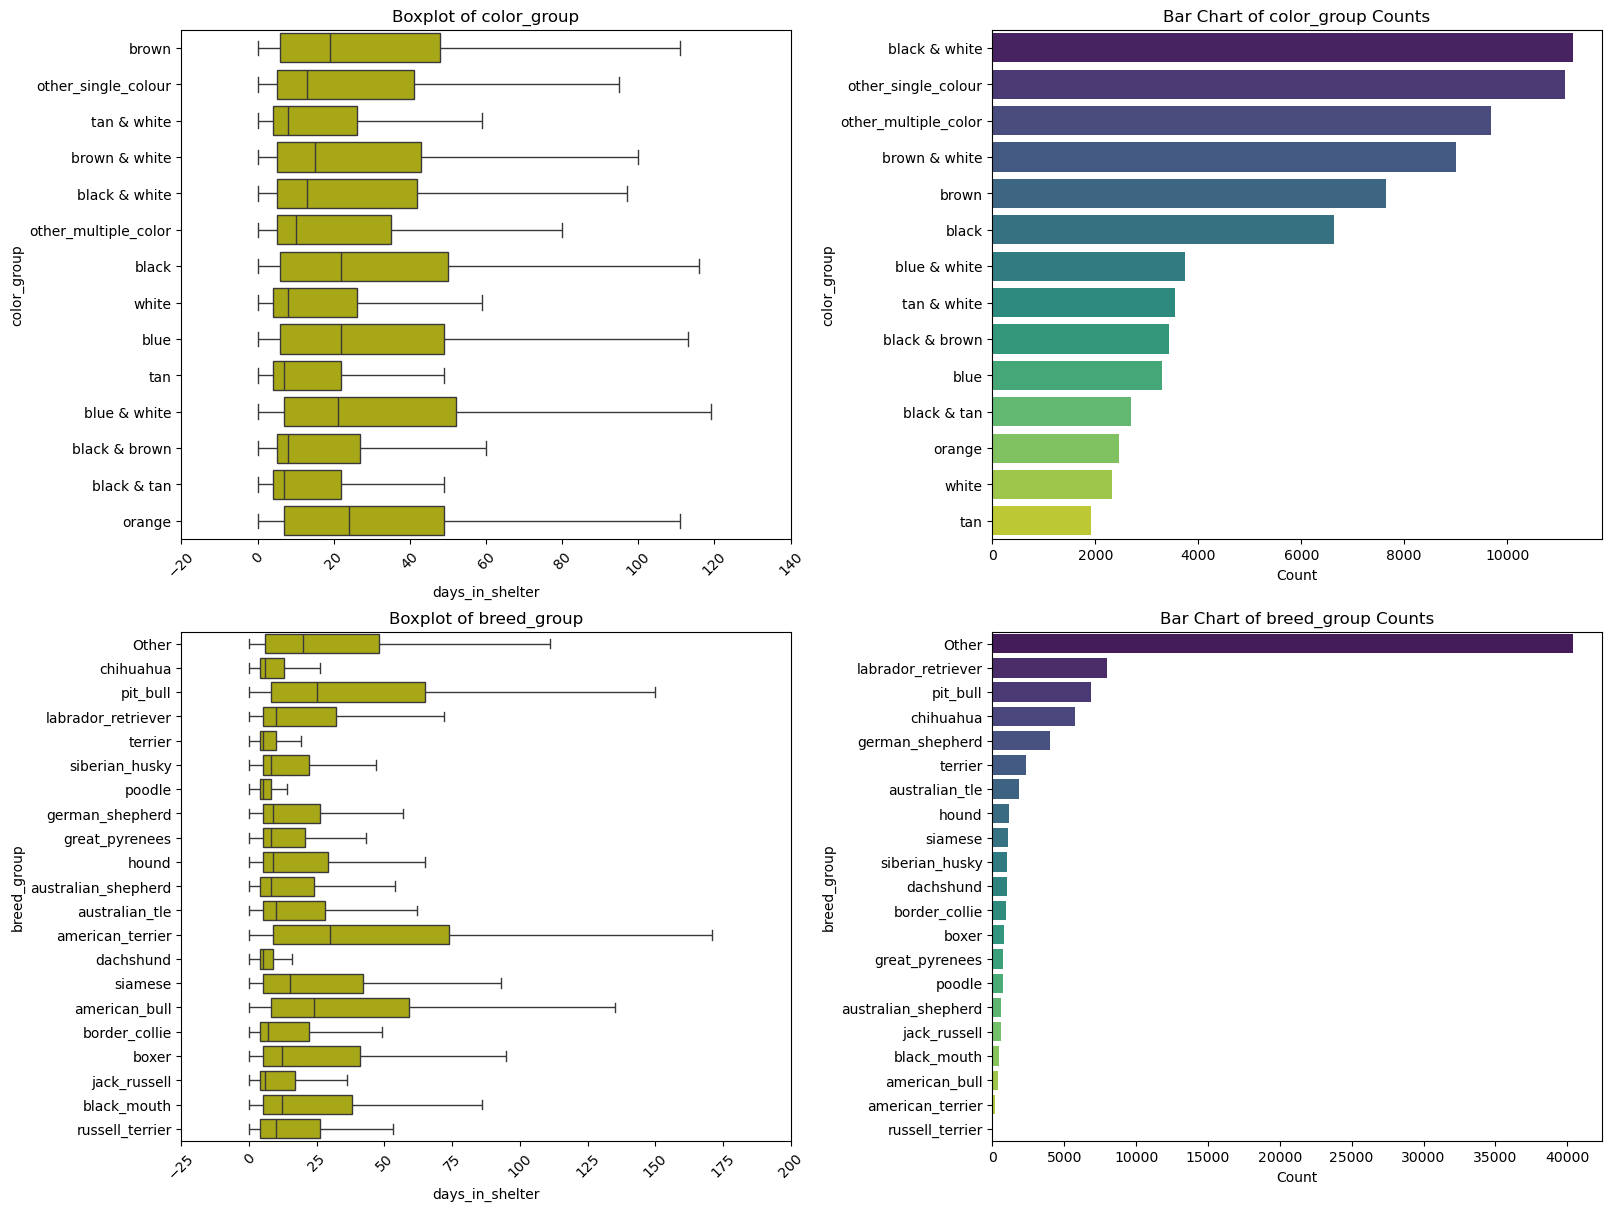

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

categories_graph = ['color_group', 'breed_group']

# Adjust grid dimensions for two graphs per category
n_cols = 2  # Two plots per category (boxplot and bar chart)
n_rows = len(categories_graph)  # One row per category
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 6), constrained_layout=True)

# Flatten axes for iteration
axes = axes.reshape(-1, n_cols) if len(categories_graph) > 1 else [axes]

for i, column in enumerate(categories_graph):
    # Boxplot
    sns.boxplot(x="days_in_shelter", y=column, data=df_eda, showfliers=False, color='y', ax=axes[i, 0])
    axes[i, 0].set_xticks(axes[i, 0].get_xticks())  # Ensure correct ticks
    axes[i, 0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels
    axes[i, 0].set_title(f'Boxplot of {column}')
    
    # Bar chart for value counts
    value_counts = df_eda[column].value_counts()
    sns.barplot(x=value_counts.values, y=value_counts.index, ax=axes[i, 1], palette='viridis')
    axes[i, 1].set_title(f'Bar Chart of {column} Counts')
    axes[i, 1].set_xlabel('Count')
    axes[i, 1].set_ylabel(column)

plt.show()


at first sight we can see how "dangerous" breeds like put bull or american bull or american terrier are taking much longer to be addopted

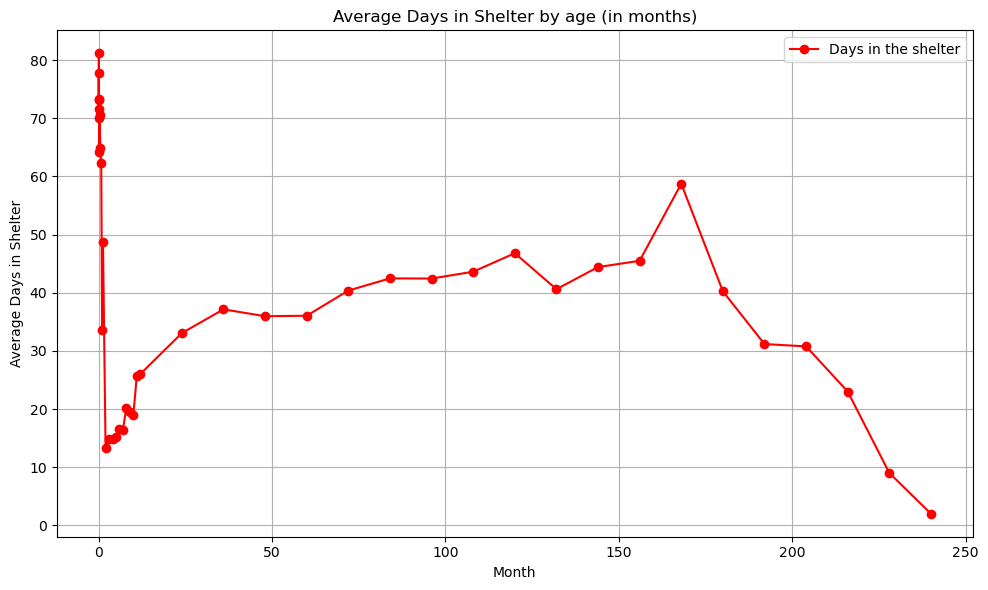

In [39]:
age_in_months = df_eda.groupby('age_in_months')['days_in_shelter'].mean().reset_index(name='avg_days_in')

plt.figure(figsize=(10, 6))
plt.plot(age_in_months['age_in_months'], age_in_months['avg_days_in'], color='r', label='Days in the shelter', linestyle='-', marker='o') 
plt.title('Average Days in Shelter by age (in months)')
plt.xlabel('Month')
plt.ylabel('Average Days in Shelter')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

* Time series of animales entering the shelter and being addopted

/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_19495/220438817.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eda['month_in'] = pd.to_datetime({
/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_19495/220438817.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eda['month_out'] = pd.to_datetime({


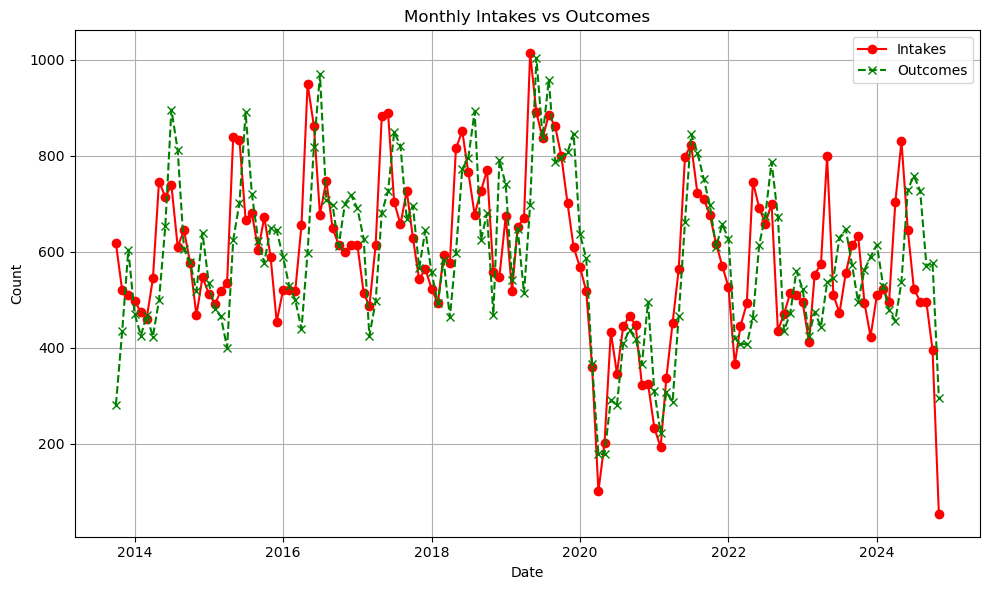

In [40]:
# Creating the 'date_out' column using year and month
df_eda['month_in'] = pd.to_datetime({
    'year': df_eda['datetime_intake'].dt.year,
    'month': df_eda['datetime_intake'].dt.month,
    'day': 1
})

# Creating the 'date_out' column using year and month 
df_eda['month_out'] = pd.to_datetime({
    'year': df_eda['datetime_outcome'].dt.year,
    'month': df_eda['datetime_outcome'].dt.month,
    'day': 1
})

# Group by 'month_in' and 'month_out' to get counts
intake_data = df_eda.groupby('month_in').size().reset_index(name='count_in')
outcome_data = df_eda.groupby('month_out').size().reset_index(name='count_out')

# Merge the two datasets on dates for consistency
merged_data = pd.merge(intake_data, outcome_data, 
                       left_on='month_in', 
                       right_on='month_out', 
                       how='outer').fillna(0)

# Rename columns for clarity
merged_data = merged_data.rename(columns={
    'month_in': 'date_in', 
    'month_out': 'date_out',
    'count_in': 'count_in',
    'count_out': 'count_out'
})

plt.figure(figsize=(10, 6))
plt.plot(merged_data['date_in'], merged_data['count_in'],color='r', label='Intakes', linestyle='-', marker='o')
plt.plot(merged_data['date_out'], merged_data['count_out'], color = 'g',label='Outcomes', linestyle='--', marker='x')

plt.title('Monthly Intakes vs Outcomes')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


Seems like a seasonal effect is present in the intakes and also we can see a huge drop in number of animals entering in 2020 and it seems to be related with COVID

/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_19495/2468792220.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_graph['month_in'] = pd.to_datetime({
/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_19495/2468792220.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_graph['month_out'] = pd.to_datetime({


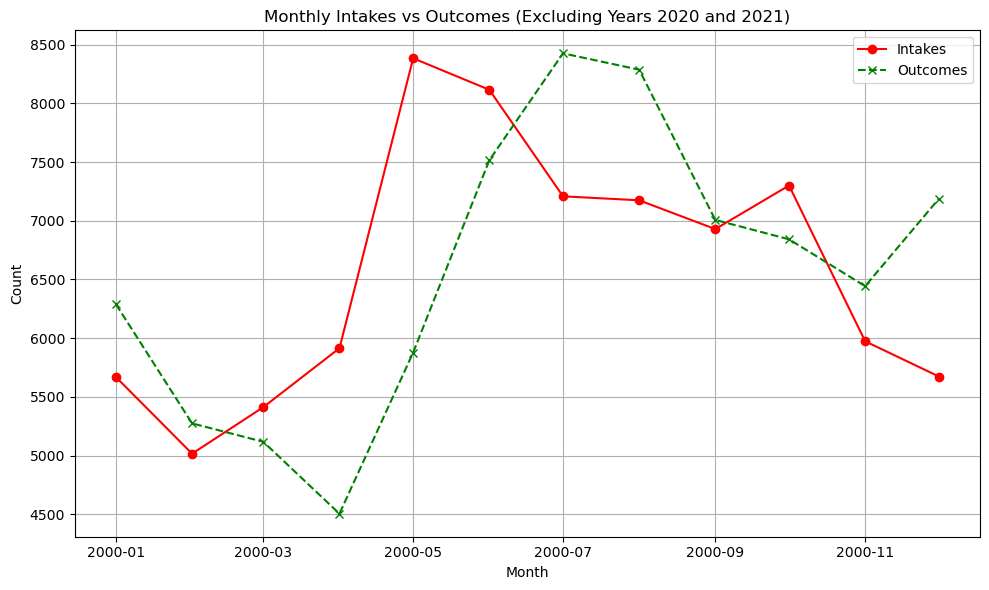

In [41]:
# Filter out years 2020 and 2021 from the DataFrame
df_graph = df_eda
[
    ~(df_eda['datetime_intake'].dt.year.isin([2020, 2021]) | 
      df_eda['datetime_outcome'].dt.year.isin([2020, 2021]))
]

# Recreate 'month_in' and 'month_out' columns
df_graph['month_in'] = pd.to_datetime({
    'year': 2000,  # Arbitrary placeholder year for visualization
    'month': df_graph['datetime_intake'].dt.month,
    'day': 1
})

df_graph['month_out'] = pd.to_datetime({
    'year': 2000,  # Arbitrary placeholder year for visualization
    'month': df_graph['datetime_outcome'].dt.month,
    'day': 1
})

# Group by 'month_in' and 'month_out' to get counts
intake_data = df_graph.groupby('month_in').size().reset_index(name='count_in')
outcome_data = df_graph.groupby('month_out').size().reset_index(name='count_out')

# Merge the two datasets on dates for consistency
merged_data = pd.merge(intake_data, outcome_data, 
                       left_on='month_in', 
                       right_on='month_out', 
                       how='outer').fillna(0)

# Rename columns for clarity
merged_data = merged_data.rename(columns={
    'month_in': 'date_in', 
    'month_out': 'date_out',
    'count_in': 'count_in',
    'count_out': 'count_out'
})

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(merged_data['date_in'], merged_data['count_in'], color='r', label='Intakes', linestyle='-', marker='o')
plt.plot(merged_data['date_out'], merged_data['count_out'], color='g', label='Outcomes', linestyle='--', marker='x')

# Customize the plot
plt.title('Monthly Intakes vs Outcomes (Excluding Years 2020 and 2021)')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


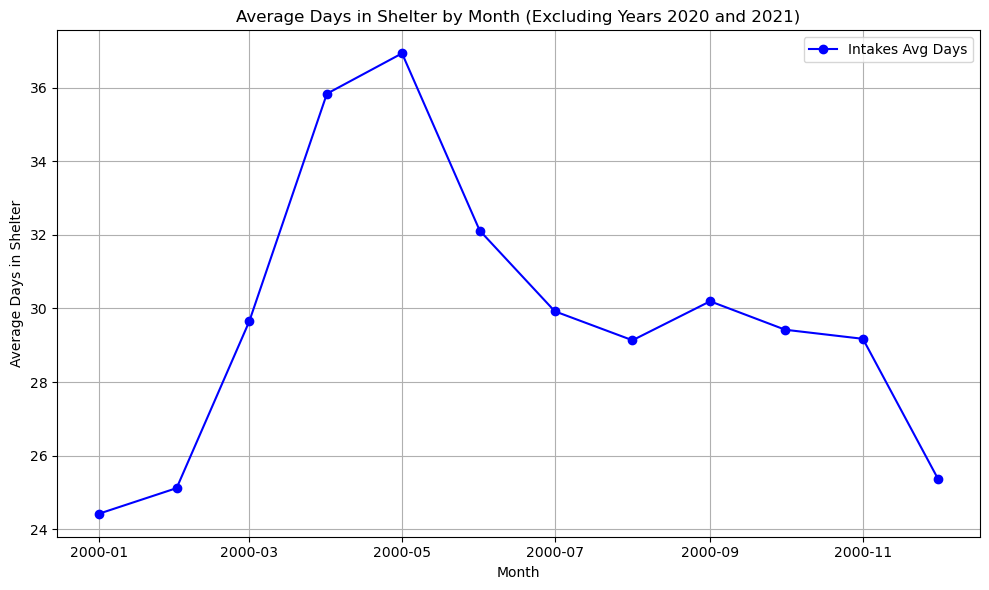

In [42]:
# Group by 'month_in' and calculate average days in shelter
intake_data = df_graph.groupby('month_in')['days_in_shelter'].mean().reset_index(name='avg_days_in')


# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(intake_data['month_in'], intake_data['avg_days_in'], color='b', label='Intakes Avg Days', linestyle='-', marker='o')
# Customize the plot
plt.title('Average Days in Shelter by Month (Excluding Years 2020 and 2021)')
plt.xlabel('Month')
plt.ylabel('Average Days in Shelter')
plt.legend()
plt.grid(True)
plt.tight_layout()

b) the day f the week when the animal entered has impact on their time in the shelter?

/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_19495/3968516512.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_graph_week['day_of_week_in'] = df_graph_week['datetime_intake'].dt.day_name()
/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_19495/3968516512.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_graph_week['day_of_week_out'] = df_graph_week['datetime_outcome'].dt.day_name()


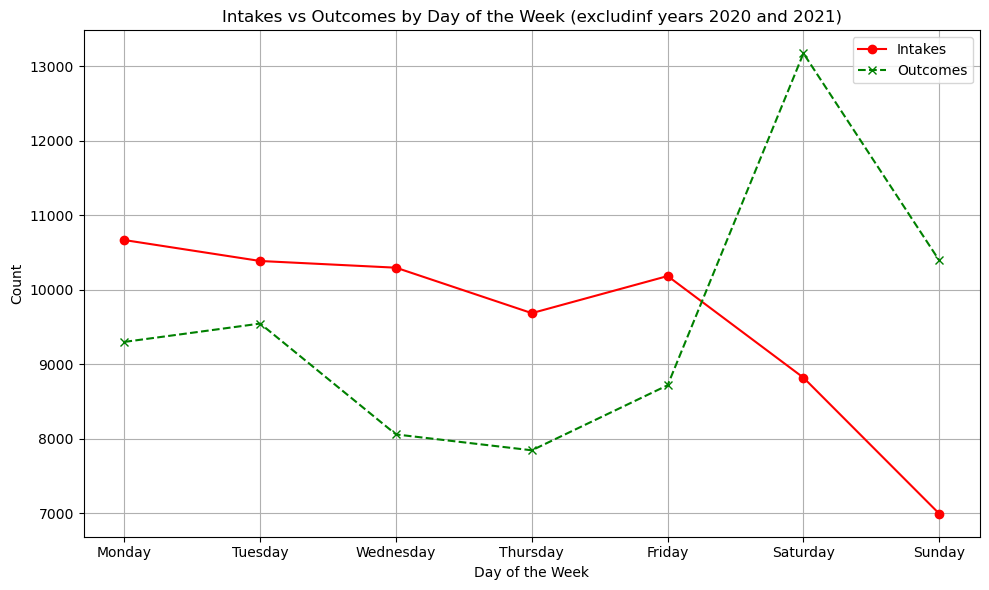

In [43]:
# Filter data for years 2020 and 2021
df_graph_week = df_eda[
   ~(df_eda['datetime_intake'].dt.year.isin([2020,2021]) | 
     df_eda['datetime_outcome'].dt.year.isin([2020,2021]))
]

# Extract the day of the week for intake and outcome dates
df_graph_week['day_of_week_in'] = df_graph_week['datetime_intake'].dt.day_name()
df_graph_week['day_of_week_out'] = df_graph_week['datetime_outcome'].dt.day_name()

# Group by 'day_of_week_in' and 'day_of_week_out' to get counts
intake_data = df_graph_week.groupby('day_of_week_in').size().reset_index(name='count_in')
outcome_data = df_graph_week.groupby('day_of_week_out').size().reset_index(name='count_out')

# Merge the two datasets on days for consistency
merged_data = pd.merge(intake_data, outcome_data, 
                       left_on='day_of_week_in', 
                       right_on='day_of_week_out', 
                       how='outer').fillna(0)

# Rename columns for clarity
merged_data = merged_data.rename(columns={
    'day_of_week_in': 'day_of_week_in',
    'day_of_week_out': 'day_of_week_out',
    'count_in': 'count_in',
    'count_out': 'count_out'
})

# Reorder days to follow the week structure
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
merged_data = merged_data.set_index('day_of_week_in').reindex(days_order).reset_index()

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(merged_data['day_of_week_in'], merged_data['count_in'], color='r', label='Intakes', linestyle='-', marker='o')
plt.plot(merged_data['day_of_week_out'], merged_data['count_out'], color='g', label='Outcomes', linestyle='--', marker='x')

# Customize the plot
plt.title('Intakes vs Outcomes by Day of the Week (excludinf years 2020 and 2021)')
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


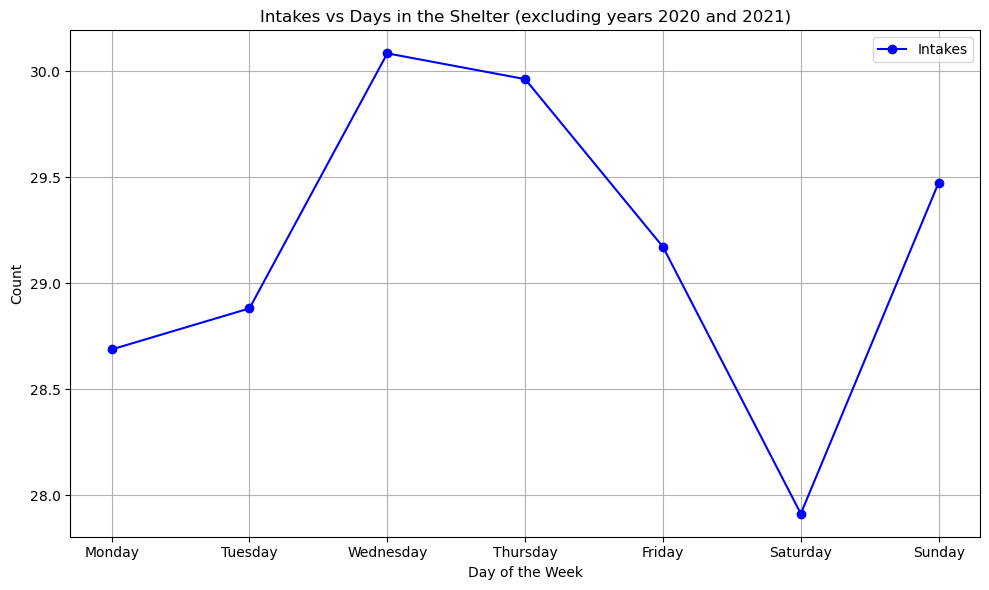

In [ ]:
# Group by 'day_of_week_in' and 'day_of_week_out' to get counts
intake_data_week= df_graph_week.groupby('day_of_week_in')['days_in_shelter'].mean().reset_index(name='count_in')


# Reorder days to follow the week structure
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
intake_data_week = intake_data_week.set_index('day_of_week_in').reindex(days_order).reset_index()

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(intake_data_week['day_of_week_in'], intake_data_week['count_in'], color='b', label='Intakes', linestyle='-', marker='o')

# Customize the plot
plt.title('Intakes vs Days in the Shelter (excluding years 2020 and 2021)')
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


d) how many animals at the same time they are?

In [ ]:
# # Function to calculate the overlap count for a given row
# def count_overlapping(row, df):
#     overlapping = df[
#         (df['datetime_intake'] <= row['datetime_outcome']) &  # Shelter intake is before or during this outcome
#         (df['datetime_outcome'] >= row['datetime_intake']) &  # Shelter outcome is after or during this intake
#         (df.index != row.name)  # Exclude the current record itself
#     ]
#     return len(overlapping)

# # Apply the function to each row
# df_eda['animals_in_shelter'] = df_eda.apply(lambda row: count_overlapping(row, df_eda), axis=1)


In [ ]:

# # Preview the updated DataFrame
# df_eda[ 'animals_in_shelter'].value_counts()


In [ ]:
# plt.figure(figsize=(10, 6))

# # Create bins for days_in_shelter
# days_bins = pd.cut(df_eda['days_in_shelter'], bins=[0, 10, 30, 60, 90, df_eda['days_in_shelter'].max()])

# sns.histplot(
#     data=df_eda,
#     x='animals_in_shelter',
#     hue=days_bins,
#     multiple="stack",  # Stacked histogram
#     bins=100,
#     kde=False
# )

# # Add title and labels
# plt.title('Histogram of Animals in Shelter by Days in Shelter')
# plt.xlabel('Number of Animals in Shelter')
# plt.ylabel('Total animals')
# plt.grid(True)

# # Add a custom legend
# plt.legend(title='Days in Shelter', labels=days_bins.cat.categories, loc='upper right')

# plt.tight_layout()
# plt.show()


In [ ]:
# plt.figure(figsize=(10, 6))
# sns.set_style('whitegrid')
# g = sns.lmplot(
#     x='days_in_shelter' , 
#     y= 'animals_in_shelter', 
#     data=df_eda,aspect=2,
#     scatter_kws={'alpha': 0.3, 'color': 'green'})
# g = (g.set_axis_labels( 'animals in the shelter', 'days in the shelter'))
# plt.title('title')
# plt.show()

In [ ]:
# # Create quantile-based bins for 'days_in_shelter'
# df_eda['days_bin'] = pd.qcut(
#     df_eda['days_in_shelter'],
#     q=4, 
#     labels=['Q1 (Lowest)', 'Q2', 'Q3', 'Q4 (Highest)'] 
# )

# # Check the binned data
# print(df_eda[['days_in_shelter', 'days_bin']].head())

# # Aggregate data: Calculate mean within each bin
# binned_data = df_eda.groupby(['days_bin', 'animal_type'], as_index=False).agg(
#     animals_in_shelter_mean=('animals_in_shelter', 'mean'),
#     days_in_shelter_mean=('days_in_shelter', 'mean')
# )

# # Plot with Seaborn lineplot
# sns.set_style('whitegrid')
# sns.set_palette('bright')

# plt.figure(figsize=(10, 6))
# sns.lineplot(
#     data=binned_data,
#     x='days_in_shelter_mean',
#     y='animals_in_shelter_mean',
#     hue='animal_type',
#     marker='o'
# )

# plt.xlabel('Days in Shelter (Mean of Quantile Bins)')
# plt.ylabel('Animals in Shelter (Mean)')
# plt.title('Animals in Shelter by Days in Quantile Bins')
# plt.legend(title='Animal Type')
# plt.show()


Animals in the shelter of the same type

In [ ]:
# # Function to calculate the overlap count for a given row, considering animal_type
# def count_overlapping_by_type(row, df):
#     overlapping = df[
#         (df['datetime_intake'] <= row['datetime_outcome']) &  # Shelter intake is before or during this outcome
#         (df['datetime_outcome'] >= row['datetime_intake']) &  # Shelter outcome is after or during this intake
#         (df['animal_type'] == row['animal_type']) &           # Same animal type
#         (df.index != row.name)  # Exclude the current record itself
#     ]
#     return len(overlapping)

# # Apply the function to each row
# df_eda['animals_in_shelter_same_type'] = df_eda.apply(lambda row: count_overlapping_by_type(row, df_eda), axis=1)


In [ ]:
# # Create quantile-based bins for 'days_in_shelter'
# df_eda['days_bin'] = pd.qcut(
#     df_eda['days_in_shelter'],
#     q=4, 
#     labels=['Q1 (Lowest)', 'Q2', 'Q3', 'Q4 (Highest)'] 
# )

# # Check the binned data
# print(df_eda[['days_in_shelter', 'days_bin']].head())

# # Aggregate data: Calculate mean within each bin
# binned_data = df_eda.groupby(['days_bin', 'animal_type'], as_index=False).agg(
#     animals_in_shelter_same_type_mean=('animals_in_shelter_same_type', 'mean'),
#     days_in_shelter_mean=('days_in_shelter', 'mean')
# )

# # Plot with Seaborn lineplot
# sns.set_style('whitegrid')
# sns.set_palette('bright')

# plt.figure(figsize=(10, 6))
# sns.lineplot(
#     data=binned_data,
#     x='days_in_shelter_mean',
#     y='animals_in_shelter_same_type_mean',
#     hue='animal_type',
#     marker='o'
# )

# plt.xlabel('Days in Shelter (Mean of Quantile Bins)')
# plt.ylabel('Animals in Shelter same type (Mean)')
# plt.title('Animals in Shelter same type by Days in Quantile Bins')
# plt.legend(title='Animal Type')
# plt.show()


-------

## Model evaluation

Chaging some features format

In [ ]:
df.columns

Index(['animal_id', 'datetime_intake', 'found_location', 'intake_type',
       'intake_condition', 'animal_type', 'sex_upon_intake',
       'datetime_outcome', 'outcome_type', 'days_in_shelter', 'castrated',
       'age_in_months', 'hair_type', 'mix_breed', 'miniature', 'domestic',
       'breed_group', 'color_group'],
      dtype='object')

In [ ]:
# df.castrated = df.castrated.map({'yes': 1, 'no': 0})
# df.castrated.value_counts()

castrated
0    60667
1    18903
Name: count, dtype: int64

In [ ]:
# df['mix_breed'] = df['mix_breed'].astype(int)
# df.mix_breed.value_counts()

mix_breed
1    48313
0    31257
Name: count, dtype: int64

In [ ]:
# df.domestic = df.domestic.astype(int)
# df.domestic.value_counts()


domestic
0    47444
1    32126
Name: count, dtype: int64

In [ ]:
# df.intake_type.value_counts()

intake_type
stray                 54601
owner surrender       22201
public assist          1676
abandoned              1078
euthanasia request       14
Name: count, dtype: int64

#### New features after EDA:


1. Day of the week the animal entered into the shelter

In [ ]:
# day of the week
df['day_of_week_in'] = df['datetime_intake'].dt.day_of_week
df['day_of_week_in'].value_counts()

day_of_week_in
0    12698
1    12633
2    12484
4    12230
3    11822
5     9879
6     7824
Name: count, dtype: int64

2. Month of intake

In [ ]:
# month of the year
df['month_in'] = df['datetime_intake'].dt.month
df['month_in'].value_counts()

month_in
5     8446
6     8174
10    7387
7     7262
8     7245
9     6992
11    6047
4     5968
1     5738
12    5732
3     5485
2     5094
Name: count, dtype: int64

3. Number of other animals from the same type in the shelter when the animal entered

In [ ]:
# Function to calculate the overlap count for a given row, considering animal_type
def count_overlapping_by_type(row, df):
    overlapping = df[
        (df['datetime_intake'] <= row['datetime_outcome']) &  # Shelter intake is before or during this outcome
        (df['datetime_outcome'] >= row['datetime_intake']) &  # Shelter outcome is after or during this intake
       # (df['animal_type'] == row['animal_type']) &           # Same animal type
       ## (df['breed_group'] == row['breed_group']) &        # Same day of the week
        (df.index != row.name)  # Exclude the current record itself
    ]
    return len(overlapping)

# Apply the function to each row
df['animals_in_shelter_same_type'] = df.apply(lambda row: count_overlapping_by_type(row, df_eda), axis=1)


In [ ]:
df.head().T

,0,1,2,3,4
animal_id,a844350,a818975,a760053,a707375,a696408
datetime_intake,2021-10-15 11:40:00,2020-06-18 14:53:00,2017-10-11 15:46:00,2015-07-11 18:19:00,2015-02-04 12:58:00
found_location,2112 east william cannon drive in austin (tx),braker lane and metric in travis (tx),8800 south first street in austin (tx),galilee court and damita jo dr in manor (tx),9705 thaxton in austin (tx)
intake_type,stray,stray,stray,stray,stray
intake_condition,normal,normal,normal,normal,normal
animal_type,cat,cat,dog,dog,dog
sex_upon_intake,female,male,male,female,female
datetime_outcome,2021-10-20 18:51:00,2020-07-23 15:54:00,2017-10-15 18:30:00,2015-11-28 17:31:00,2015-05-28 11:24:00
outcome_type,adoption,adoption,adoption,adoption,adoption
days_in_shelter,5,35,4,139,112


In [ ]:
df.columns

Index(['animal_id', 'datetime_intake', 'found_location', 'intake_type',
       'intake_condition', 'animal_type', 'sex_upon_intake',
       'datetime_outcome', 'outcome_type', 'days_in_shelter', 'castrated',
       'age_in_months', 'hair_type', 'mix_breed', 'miniature', 'domestic',
       'breed_group', 'color_group', 'day_of_week_in', 'month_in',
       'animals_in_shelter_same_type'],
      dtype='object')

In [ ]:
# removeoutliers from the dataset with >= 99% quantile
df = df[df['days_in_shelter'] < df['days_in_shelter'].quantile(0.99)]


## Training models

Preparing the training dataset, validation and test dataset.

In [ ]:
numerical = ['age_in_months', 'month_in', 'animals_in_shelter_same_type','day_of_week_in']
  
categorical = [    
    #'found_location', 
    'intake_type',
    'intake_condition', 
    'animal_type', 
    'sex_upon_intake',
    'castrated',
    'hair_type',
    'mix_breed', 
    'miniature', 
    'domestic',
   # 'day_of_week_in',
     'breed_group',     
     'color_group'
]
#   

In [ ]:
# checckiing for missing values in columns inside numerical or categorical
missing_numerical = df[numerical].isnull().sum()
missing_categorical = df[categorical].isnull().sum()

print(f"Missing values in numerical columns:\n{missing_numerical[missing_numerical > 0]}\n")
print(f"Missing values in categorical columns:\n{missing_categorical[missing_categorical > 0]}")


Missing values in numerical columns:
Series([], dtype: int64)

Missing values in categorical columns:
Series([], dtype: int64)


For training the model we will use the whole dataset except the last 20% of the records ordered by datetime_intake that would be the test

In [ ]:
# for test: last 20% of the records based on the datetime_intake column
df.reset_index(drop=True, inplace=True)
df_test = df.sort_values('datetime_intake').tail(int(len(df) * 0.2))
print('test df from: ',df_test['datetime_intake'].min(), 'test df to: ' ,df_test['datetime_intake'].max())

# for train: the rest of the records that I will divide into train and validation sets
df_full_train = df.drop(df_test.index)
df_train, df_val = train_test_split(df_full_train, test_size=0.20, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.days_in_shelter.values
y_val = df_val.days_in_shelter.values
y_test = df_test.days_in_shelter.values

del df_train['days_in_shelter']
del df_val['days_in_shelter']
del df_test['days_in_shelter']

test df from:  2022-06-21 16:07:00 test df to:  2024-11-10 13:10:00


In [ ]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)


In [ ]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)  # Use transform, not fit_transform


In [ ]:
print(dv.feature_names_)

['age_in_months', 'animal_type=cat', 'animal_type=dog', 'animals_in_shelter_same_type', 'breed_group=Other', 'breed_group=american_bull', 'breed_group=american_terrier', 'breed_group=australian_shepherd', 'breed_group=australian_tle', 'breed_group=black_mouth', 'breed_group=border_collie', 'breed_group=boxer', 'breed_group=chihuahua', 'breed_group=dachshund', 'breed_group=german_shepherd', 'breed_group=great_pyrenees', 'breed_group=hound', 'breed_group=jack_russell', 'breed_group=labrador_retriever', 'breed_group=pit_bull', 'breed_group=poodle', 'breed_group=russell_terrier', 'breed_group=siamese', 'breed_group=siberian_husky', 'breed_group=terrier', 'castrated=no', 'castrated=yes', 'color_group=black', 'color_group=black & brown', 'color_group=black & tan', 'color_group=black & white', 'color_group=blue', 'color_group=blue & white', 'color_group=brown', 'color_group=brown & white', 'color_group=orange', 'color_group=other_multiple_color', 'color_group=other_single_colour', 'color_grou

### Linear Regression

In [ ]:
lr_model = LinearRegression()

lr_model.fit(X_train, y_train)
y_val_pred = lr_model.predict(X_val)

mae = mean_absolute_error(y_val, y_val_pred)
mse = mean_squared_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"RMSE: {np.sqrt(mse):.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.2f}")


Mean Absolute Error (MAE): 10.06
RMSE: 14.56
Mean Squared Error (MSE): 212.01
R² Score: 0.87


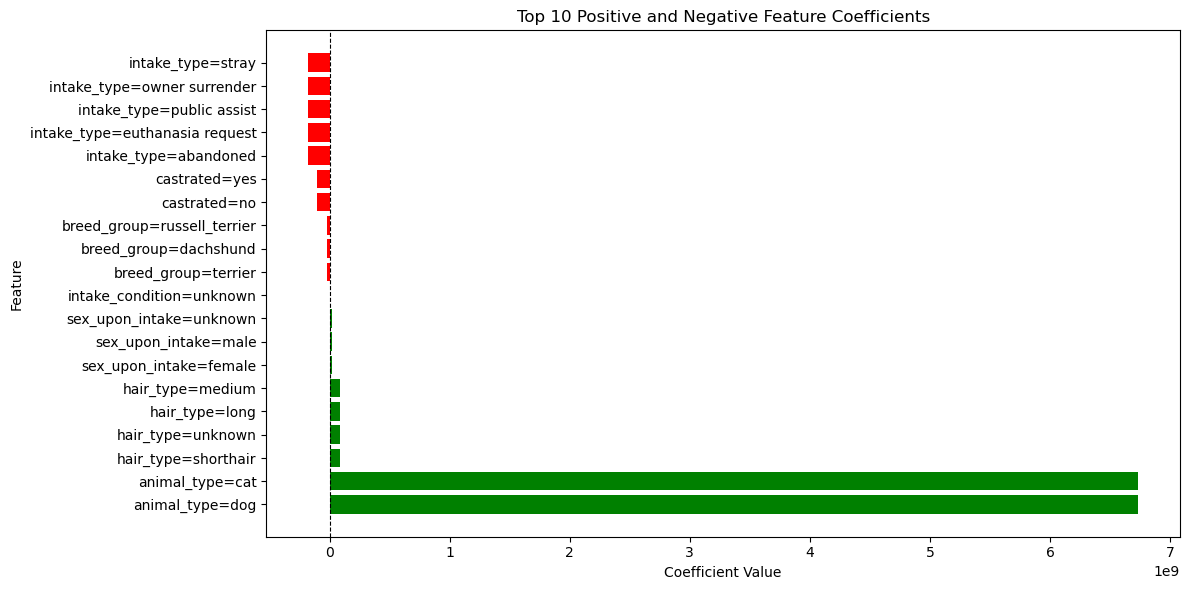

In [ ]:
feature_importance = pd.DataFrame({
    'Feature': dv.feature_names_,
    'Coefficient': lr_model.coef_ 
}).sort_values(by='Coefficient', ascending=False)
 
feature_importance['Coefficient'] = feature_importance['Coefficient'].round(3)


feature_importance = pd.DataFrame(feature_importance).sort_values(by='Coefficient', ascending=False)

# Plotting top 10 positive and negative features
top_positive = feature_importance.head(10)
top_negative = feature_importance.tail(10)

# Combine both for unified plotting
top_features = pd.concat([top_positive, top_negative])

plt.figure(figsize=(12, 6))
plt.barh(top_features['Feature'], top_features['Coefficient'], color=['green' if coef > 0 else 'red' for coef in top_features['Coefficient']])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 10 Positive and Negative Feature Coefficients')
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')  # Adding a vertical line at zero
plt.tight_layout()
plt.show()


In [ ]:
from IPython.display import display

# Display styled DataFrame
display(feature_importance.style)


,Feature,Coefficient
2,animal_type=dog,6736107593.819000
1,animal_type=cat,6736107592.998000
45,hair_type=shorthair,85524514.813000
46,hair_type=unknown,85524514.669000
43,hair_type=long,85524514.165000
44,hair_type=medium,85524513.956000
68,sex_upon_intake=female,18078403.602000
69,sex_upon_intake=male,18078403.535000
70,sex_upon_intake=unknown,18078402.956000
59,intake_condition=unknown,5519043.700000


In [ ]:
from sklearn.model_selection import cross_val_score
 
scores = cross_val_score(LinearRegression(), X_train, y_train, scoring='neg_mean_squared_error', cv=5) 

rmse_scores = (-scores)**0.5
 
rmse_mean = np.mean(rmse_scores)
rmse_std = np.std(rmse_scores)
 
sem = rmse_std / np.sqrt(len(rmse_scores))

# 95% confidence interval
z = 1.96  
lower_bound = rmse_mean - z * sem
upper_bound = rmse_mean + z * sem

# Print results
print(f"Cross-Validated RMSE: {rmse_mean:.2f}")
print(f"95% Confidence Interval: [{lower_bound:.2f}, {upper_bound:.2f}]")


Cross-Validated RMSE: 14.79
95% Confidence Interval: [14.60, 14.99]


#### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [ ]:
y_pred = rf.predict(X_val)
root_mean_squared_error(y_val, y_pred)

11.262449826280438

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [ ]:
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error

In [ ]:
scores = []

rf = RandomForestRegressor(
    n_estimators=1,
    random_state=1,
    n_jobs=-1,
    warm_start=True,
)

for n in tqdm(range(10, 201, 10)):
    rf.n_estimators = n
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    
    scores.append((n, score))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

  0%|          | 0/20 [00:00<?, ?it/s]

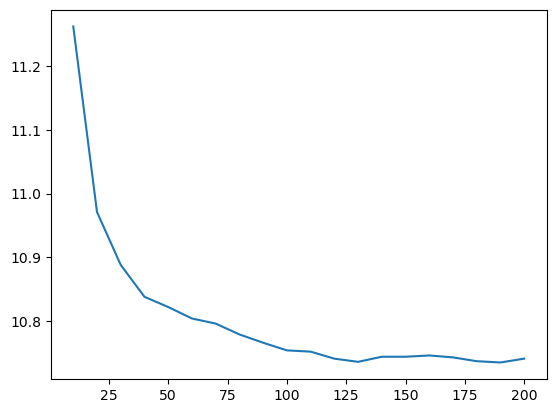

In [ ]:
#plt.plot(df_scores.n_estimators, df_scores.rmse)
plt.plot(df_scores.n_estimators, df_scores.rmse.round(3))

plt.show()

In [ ]:
scores = []

for d in tqdm([10, 15, 20, 25, 35,40, 45, 55]):
    rf = RandomForestRegressor(
        n_estimators=0,
        max_depth=d,
        random_state=1,
        n_jobs=-1,
        warm_start=True
    )

    for n in tqdm(range(10, 201, 10)):
        rf.n_estimators = n
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))

        scores.append((d, n, score))

columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

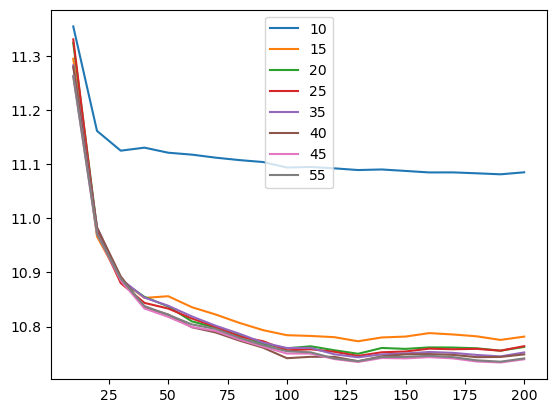

In [ ]:
for d in [10, 15, 20, 25, 35, 40,45, 55]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=d)

plt.legend()
plt.show()

In [ ]:
rf = RandomForestRegressor(
    n_estimators=35,
    max_depth=45,
    random_state=1,
    n_jobs=-1
)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=45, n_estimators=35, n_jobs=-1, random_state=1)

In [ ]:
y_pred = rf.predict(X_val)
root_mean_squared_error(y_val, y_pred)

10.865999251807086

In [ ]:
df_importances = pd.DataFrame()
df_importances['feature'] = dv.feature_names_
df_importances['importance'] = rf.feature_importances_
df_importances.sort_values(by='importance', ascending=False).head(15)

,feature,importance
3,animals_in_shelter_same_type,0.888308
67,month_in,0.044968
0,age_in_months,0.015334
41,day_of_week_in,0.006938
66,mix_breed,0.005292
34,color_group=brown & white,0.001509
30,color_group=black & white,0.001475
19,breed_group=pit_bull,0.001465
33,color_group=brown,0.001427
36,color_group=other_multiple_color,0.001411


#### XGboost

In [ ]:
import io
from contextlib import redirect_stdout
import xgboost as xgb
from sklearn.metrics import mean_squared_error
 
features = list(dv.get_feature_names_out())  # Assuming `dv` is your DictVectorizer or similar

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

# Watchlist for monitoring training and validation
watchlist = [(dtrain, 'train'), (dval, 'val')]



In [ ]:
# XGBoost parameters for regression
xgb_params = {
    'eta': 0.05,                 # Learning rate
    'max_depth': 6,              # Maximum depth of trees
    'min_child_weight': 1,       # Minimum weight sum of child nodes
    'objective': 'reg:squarederror',  # Regression objective
    'nthread': 8,                # Number of threads
    'seed': 1,                   # Random seed
    'verbosity': 1,              # Verbosity level
    'eval_metric': 'rmse'        # Metric for monitoring performance
}



In [ ]:
# Redirect stdout to capture output
f = io.StringIO()
with redirect_stdout(f):
    model = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=200,        # Number of boosting rounds
        verbose_eval=5,             # Print every 5 rounds
        evals=watchlist             # Training and validation sets for monitoring
    )

captured_output = f.getvalue()
print("Captured Output:\n")
print(captured_output)

y_pred = model.predict(dval)
rmse = mean_squared_error(y_val, y_pred, squared=False)
print(f"Root Mean Squared Error: {rmse}")

evals_result = {}

# Train again to capture results for plotting
model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=200,
    evals=watchlist,
    verbose_eval=5,
    evals_result=evals_result
)

Captured Output:

[0]	train-rmse:38.01657	val-rmse:38.41677
[5]	train-rmse:30.46380	val-rmse:30.72523
[10]	train-rmse:24.81079	val-rmse:24.97788
[15]	train-rmse:20.64046	val-rmse:20.75858
[20]	train-rmse:17.61575	val-rmse:17.70605
[25]	train-rmse:15.46607	val-rmse:15.54646
[30]	train-rmse:13.97627	val-rmse:14.05895
[35]	train-rmse:12.96109	val-rmse:13.07100
[40]	train-rmse:12.27488	val-rmse:12.41737
[45]	train-rmse:11.80858	val-rmse:11.99357
[50]	train-rmse:11.47770	val-rmse:11.70119
[55]	train-rmse:11.23499	val-rmse:11.49738
[60]	train-rmse:11.06603	val-rmse:11.35987
[65]	train-rmse:10.92753	val-rmse:11.25522
[70]	train-rmse:10.82642	val-rmse:11.18359
[75]	train-rmse:10.74821	val-rmse:11.14085
[80]	train-rmse:10.67074	val-rmse:11.10496
[85]	train-rmse:10.59829	val-rmse:11.06202
[90]	train-rmse:10.54190	val-rmse:11.04173
[95]	train-rmse:10.50669	val-rmse:11.02256
[100]	train-rmse:10.45798	val-rmse:11.00493
[105]	train-rmse:10.41043	val-rmse:10.98530
[110]	train-rmse:10.36801	val-rmse:1

/opt/anaconda3/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[40]	train-rmse:12.27488	val-rmse:12.41737
[45]	train-rmse:11.80858	val-rmse:11.99357
[50]	train-rmse:11.47770	val-rmse:11.70119
[55]	train-rmse:11.23499	val-rmse:11.49738
[60]	train-rmse:11.06603	val-rmse:11.35987
[65]	train-rmse:10.92753	val-rmse:11.25522
[70]	train-rmse:10.82642	val-rmse:11.18359
[75]	train-rmse:10.74821	val-rmse:11.14085
[80]	train-rmse:10.67074	val-rmse:11.10496
[85]	train-rmse:10.59829	val-rmse:11.06202
[90]	train-rmse:10.54190	val-rmse:11.04173
[95]	train-rmse:10.50669	val-rmse:11.02256
[100]	train-rmse:10.45798	val-rmse:11.00493
[105]	train-rmse:10.41043	val-rmse:10.98530
[110]	train-rmse:10.36801	val-rmse:10.97360
[115]	train-rmse:10.33787	val-rmse:10.95730
[120]	train-rmse:10.32167	val-rmse:10.95110
[125]	train-rmse:10.30066	val-rmse:10.94121
[130]	train-rmse:10.28695	val-rmse:10.93759
[135]	train-rmse:10.26672	val-rmse:10.93047
[140]	train-rmse:10.24824	val-rmse:10.92323
[145]	train-rmse:10.23709	val-rmse:10.91872
[150]	train-rmse:10.21675	val-rmse:10.91738


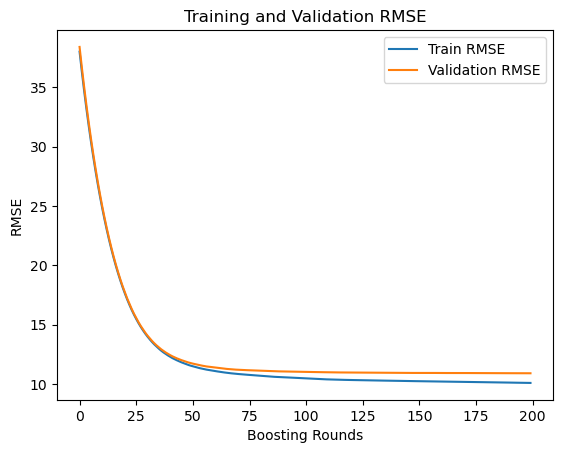

In [ ]:

# Plot the evaluation metrics
train_rmse = evals_result['train']['rmse']
val_rmse = evals_result['val']['rmse']

plt.plot(train_rmse, label='Train RMSE')
plt.plot(val_rmse, label='Validation RMSE')
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.title('Training and Validation RMSE')
plt.legend()
plt.show()


In [ ]:
model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=200,  # Maximum boosting rounds
    evals=watchlist,
    verbose_eval=5,
    early_stopping_rounds=10 # Stop if no improvement for 10 rounds
) 

[0]	train-rmse:38.01657	val-rmse:38.41677


[5]	train-rmse:30.46380	val-rmse:30.72523
[10]	train-rmse:24.81079	val-rmse:24.97788
[15]	train-rmse:20.64046	val-rmse:20.75858
[20]	train-rmse:17.61575	val-rmse:17.70605
[25]	train-rmse:15.46607	val-rmse:15.54646
[30]	train-rmse:13.97627	val-rmse:14.05895
[35]	train-rmse:12.96109	val-rmse:13.07100
[40]	train-rmse:12.27488	val-rmse:12.41737
[45]	train-rmse:11.80858	val-rmse:11.99357
[50]	train-rmse:11.47770	val-rmse:11.70119
[55]	train-rmse:11.23499	val-rmse:11.49738
[60]	train-rmse:11.06603	val-rmse:11.35987
[65]	train-rmse:10.92753	val-rmse:11.25522
[70]	train-rmse:10.82642	val-rmse:11.18359
[75]	train-rmse:10.74821	val-rmse:11.14085
[80]	train-rmse:10.67074	val-rmse:11.10496
[85]	train-rmse:10.59829	val-rmse:11.06202
[90]	train-rmse:10.54190	val-rmse:11.04173
[95]	train-rmse:10.50669	val-rmse:11.02256
[100]	train-rmse:10.45798	val-rmse:11.00493
[105]	train-rmse:10.41043	val-rmse:10.98530
[110]	train-rmse:10.36801	val-rmse:10.97360
[115]	train-rmse:10.33787	val-rmse:10.95730
[120]	tr

In [ ]:
y_pred = model.predict(dval)
rmse = mean_squared_error(y_val, y_pred, squared=False)
print(f"Validation RMSE: {rmse}")

Validation RMSE: 10.888460228607464


/opt/anaconda3/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Hyperparameter tunning

ETA

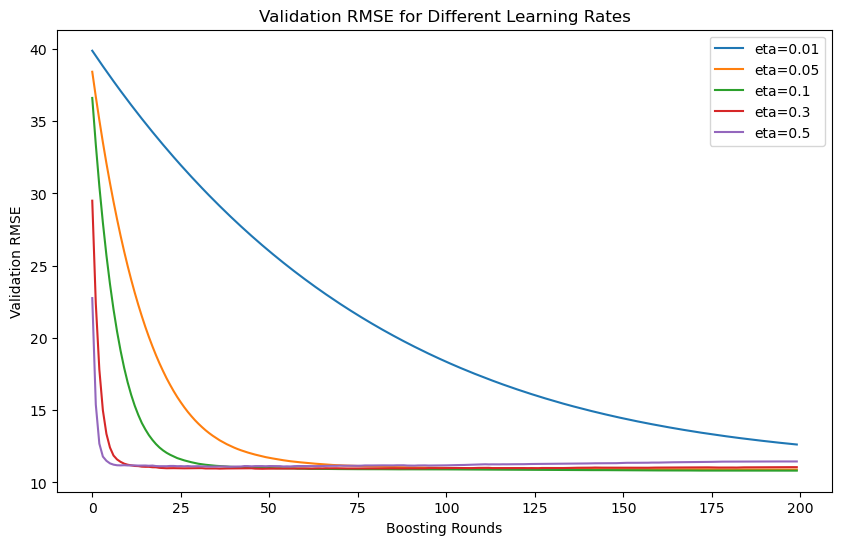

Final RMSE for eta=0.01: 12.623298621691413
Final RMSE for eta=0.05: 10.888460233757808
Final RMSE for eta=0.1: 10.815960999591093
Final RMSE for eta=0.3: 11.054313789492095
Final RMSE for eta=0.5: 11.449715655699336


In [ ]:
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Define a function to train the model and capture results
def train_xgboost(eta, num_boost_round, early_stopping_rounds=None):
    xgb_params = {
        'eta': eta,                  # Learning rate
        'max_depth': 6,              # Maximum depth of trees
        'min_child_weight': 1,       # Minimum weight sum of child nodes
        'objective': 'reg:squarederror',  # Regression objective
        'nthread': 8,                # Number of threads
        'seed': 1,                   # Random seed
        'verbosity': 1,              # Verbosity level
        'eval_metric': 'rmse'        # Metric for monitoring performance
    }

    evals_result = {}

    model = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=num_boost_round,
        evals=watchlist,
        verbose_eval=False,  # Suppress output during training
        early_stopping_rounds=early_stopping_rounds,
        evals_result=evals_result
    )
    
    return evals_result, model
 
results = {}
for eta in [0.01,0.05,0.1, 0.3, 0.5]:
    evals_result, model = train_xgboost(eta=eta, num_boost_round=200)
    results[eta] = evals_result

# Plot the RMSE for both learning rates
plt.figure(figsize=(10, 6))

for eta, evals_result in results.items():
    val_rmse = evals_result['val']['rmse']
    plt.plot(range(len(val_rmse)), val_rmse, label=f'eta={eta}')

plt.xlabel('Boosting Rounds')
plt.ylabel('Validation RMSE')
plt.title('Validation RMSE for Different Learning Rates')
plt.legend()
plt.show()

# To print final RMSE for each case
for eta, evals_result in results.items():
    print(f"Final RMSE for eta={eta}: {evals_result['val']['rmse'][-1]}")


max_depth

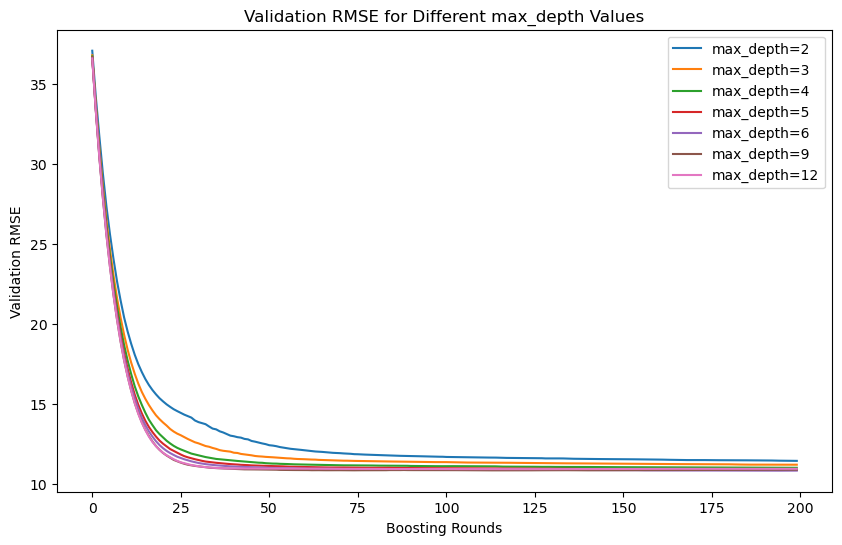

Final RMSE for max_depth=2: 11.425361803735642
Final RMSE for max_depth=3: 11.185769801735642
Final RMSE for max_depth=4: 10.992456350627345
Final RMSE for max_depth=5: 10.880717110528225
Final RMSE for max_depth=6: 10.815960999591093
Final RMSE for max_depth=9: 10.873688127985753
Final RMSE for max_depth=12: 10.930920827721684


In [ ]:
# Define a function to train models with varying max_depth
def train_xgboost_with_max_depth(max_depth, num_boost_round, eta=0.1, early_stopping_rounds=None):
    xgb_params = {
        'eta': eta,                  # Learning rate
        'max_depth': max_depth,      # Varying max depth
        'min_child_weight': 1,       # Minimum weight sum of child nodes
        'objective': 'reg:squarederror',  # Regression objective
        'nthread': 8,                # Number of threads
        'seed': 1,                   # Random seed
        'verbosity': 1,              # Verbosity level
        'eval_metric': 'rmse'}
                        

    evals_result = {}

    model = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=num_boost_round,
        evals=watchlist,
        verbose_eval=False,  # Suppress output during training
        early_stopping_rounds=early_stopping_rounds,
        evals_result=evals_result
    )
    
    return evals_result, model

# Train models with different max_depth values
max_depth_values = [2, 3, 4,5, 6, 9, 12]
results = {}

for max_depth in max_depth_values:
    evals_result, model = train_xgboost_with_max_depth(max_depth=max_depth, num_boost_round=200)
    results[max_depth] = evals_result

# Plot the RMSE for each max_depth
plt.figure(figsize=(10, 6))

for max_depth, evals_result in results.items():
    val_rmse = evals_result['val']['rmse']
    plt.plot(range(len(val_rmse)), val_rmse, label=f'max_depth={max_depth}')

plt.xlabel('Boosting Rounds')
plt.ylabel('Validation RMSE')
plt.title('Validation RMSE for Different max_depth Values')
plt.legend()
plt.show()

# Print final RMSE for each max_depth
for max_depth, evals_result in results.items():
    print(f"Final RMSE for max_depth={max_depth}: {evals_result['val']['rmse'][-1]}")


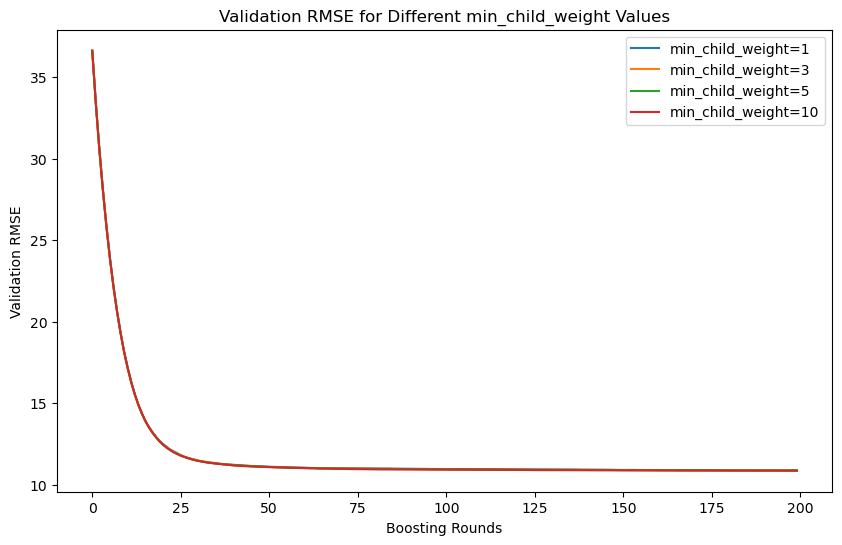

Final RMSE for min_child_weight=1: 10.880717110528225
Final RMSE for min_child_weight=3: 10.862593127921986
Final RMSE for min_child_weight=5: 10.883196931864807
Final RMSE for min_child_weight=10: 10.863582706273448


In [ ]:
# Define a function to train models with varying min_child_weight
def train_xgboost_with_min_child_weight(min_child_weight, num_boost_round, eta=0.1, max_depth=5, early_stopping_rounds=None):
    xgb_params = {
        'eta': eta,                  # Learning rate
        'max_depth': max_depth,      # Depth of trees
        'min_child_weight': min_child_weight,  # Minimum sum of weights in child nodes
        'objective': 'reg:squarederror',  # Regression objective
        'nthread': 8,                # Number of threads
        'seed': 1,                   # Random seed
        'verbosity': 1,              # Verbosity level
        'eval_metric': 'rmse'        # Metric for monitoring performance
    }

    evals_result = {}

    model = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=num_boost_round,
        evals=watchlist,
        verbose_eval=False,  # Suppress output during training
        early_stopping_rounds=early_stopping_rounds,
        evals_result=evals_result
    )
    
    return evals_result, model

# Train models with different min_child_weight values
min_child_weight_values = [1, 3, 5, 10]
results = {}

for min_child_weight in min_child_weight_values:
    evals_result, model = train_xgboost_with_min_child_weight(min_child_weight=min_child_weight, num_boost_round=200)
    results[min_child_weight] = evals_result

# Plot the RMSE for each min_child_weight
plt.figure(figsize=(10, 6))

for min_child_weight, evals_result in results.items():
    val_rmse = evals_result['val']['rmse']
    plt.plot(range(len(val_rmse)), val_rmse, label=f'min_child_weight={min_child_weight}')

plt.xlabel('Boosting Rounds')
plt.ylabel('Validation RMSE')
plt.title('Validation RMSE for Different min_child_weight Values')
plt.legend()
plt.show()

# Print final RMSE for each min_child_weight
for min_child_weight, evals_result in results.items():
    print(f"Final RMSE for min_child_weight={min_child_weight}: {evals_result['val']['rmse'][-1]}")


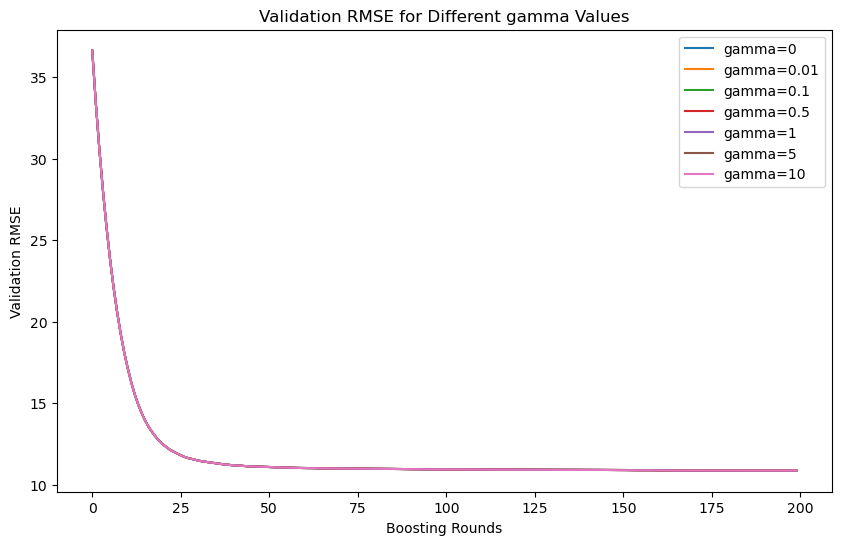

Final RMSE for gamma=0: 10.862593127921986
Final RMSE for gamma=0.01: 10.862593127921986
Final RMSE for gamma=0.1: 10.862593127921986
Final RMSE for gamma=0.5: 10.862593127921986
Final RMSE for gamma=1: 10.862593127921986
Final RMSE for gamma=5: 10.862942227849999
Final RMSE for gamma=10: 10.871001569209493


In [ ]:
# Define a function to train models with varying gamma
def train_xgboost_with_gamma(gamma, num_boost_round, eta=0.1, max_depth=5,  min_child_weight=3,  early_stopping_rounds=None):
    xgb_params = {
        'eta': eta,                      # Learning rate
        'max_depth': max_depth,          # Depth of trees
        'gamma': gamma,                  # Minimum loss reduction to split
        'min_child_weight': min_child_weight,  # Minimum sum of weights in child nodes
        'objective': 'reg:squarederror', # Regression objective
        'nthread': 8,                    # Number of threads
        'seed': 1,                       # Random seed
        'verbosity': 1,                  # Verbosity level
        'eval_metric': 'rmse'            # Metric for monitoring performance
    }

    evals_result = {}

    model = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=num_boost_round,
        evals=watchlist,
        verbose_eval=False,  # Suppress output during training
        early_stopping_rounds=early_stopping_rounds,
        evals_result=evals_result
    )
    
    return evals_result, model

# Test different gamma values
gamma_values = [0, 0.01, 0.1, 0.5, 1, 5, 10]
results_gamma = {}

for gamma in gamma_values:
    evals_result, model = train_xgboost_with_gamma(gamma=gamma, num_boost_round=200)
    results_gamma[gamma] = evals_result

# Plot the RMSE for different gamma values
plt.figure(figsize=(10, 6))

for gamma, evals_result in results_gamma.items():
    val_rmse = evals_result['val']['rmse']
    plt.plot(range(len(val_rmse)), val_rmse, label=f'gamma={gamma}')

plt.xlabel('Boosting Rounds')
plt.ylabel('Validation RMSE')
plt.title('Validation RMSE for Different gamma Values')
plt.legend()
plt.show()

# Print final RMSE for each gamma value
for gamma, evals_result in results_gamma.items():
    print(f"Final RMSE for gamma={gamma}: {evals_result['val']['rmse'][-1]}")


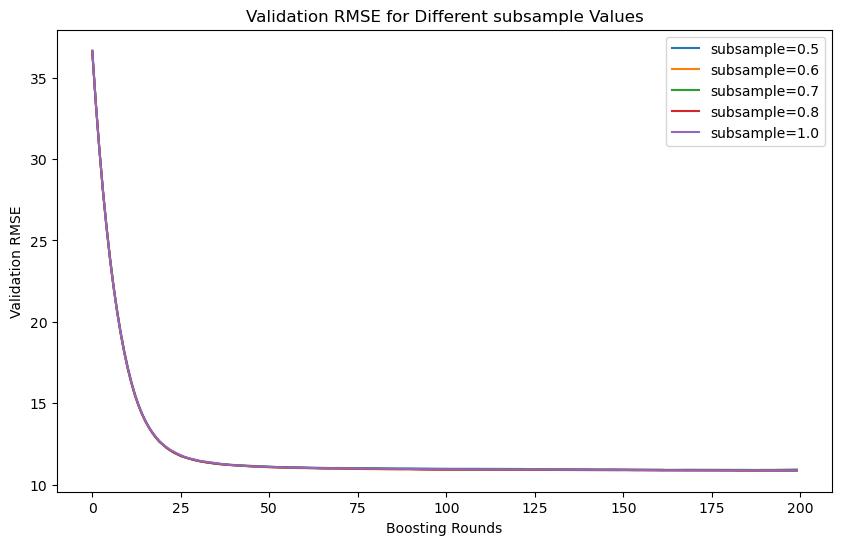

Final RMSE for subsample=0.5: 10.926271783769934
Final RMSE for subsample=0.6: 10.888693843760894
Final RMSE for subsample=0.7: 10.883345615221957
Final RMSE for subsample=0.8: 10.858002740763256
Final RMSE for subsample=1.0: 10.862593127921986


In [ ]:
# Define a function to train models with varying subsample
def train_xgboost_with_subsample(subsample, num_boost_round,gamma = 0.1, eta=0.1, max_depth=5,  min_child_weight=3, early_stopping_rounds=None):
    xgb_params = {
        'eta': eta,                      # Learning rate
        'max_depth': max_depth,          # Depth of trees
        'gamma': gamma,                  # Minimum loss reduction to split
        'subsample': subsample,          # Fraction of data for each tree 
        'min_child_weight': min_child_weight,  # Minimum sum of weights in child nodes
        'objective': 'reg:squarederror', # Regression objective
        'nthread': 8,                    # Number of threads
        'seed': 1,                       # Random seed
        'verbosity': 1,                  # Verbosity level
        'eval_metric': 'rmse'            # Metric for monitoring performance
    }

    evals_result = {}

    model = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=num_boost_round,
        evals=watchlist,
        verbose_eval=False,  # Suppress output during training
        early_stopping_rounds=early_stopping_rounds,
        evals_result=evals_result
    )
    
    return evals_result, model

# Test different subsample values
subsample_values = [0.5, 0.6, 0.7, 0.8, 1.0]
results_subsample = {}

for subsample in subsample_values:
    evals_result, model = train_xgboost_with_subsample(subsample=subsample, num_boost_round=200)
    results_subsample[subsample] = evals_result

# Plot the RMSE for different subsample values
plt.figure(figsize=(10, 6))

for subsample, evals_result in results_subsample.items():
    val_rmse = evals_result['val']['rmse']
    plt.plot(range(len(val_rmse)), val_rmse, label=f'subsample={subsample}')

plt.xlabel('Boosting Rounds')
plt.ylabel('Validation RMSE')
plt.title('Validation RMSE for Different subsample Values')
plt.legend()
plt.show()

# Print final RMSE for each subsample value
for subsample, evals_result in results_subsample.items():
    print(f"Final RMSE for subsample={subsample}: {evals_result['val']['rmse'][-1]}")


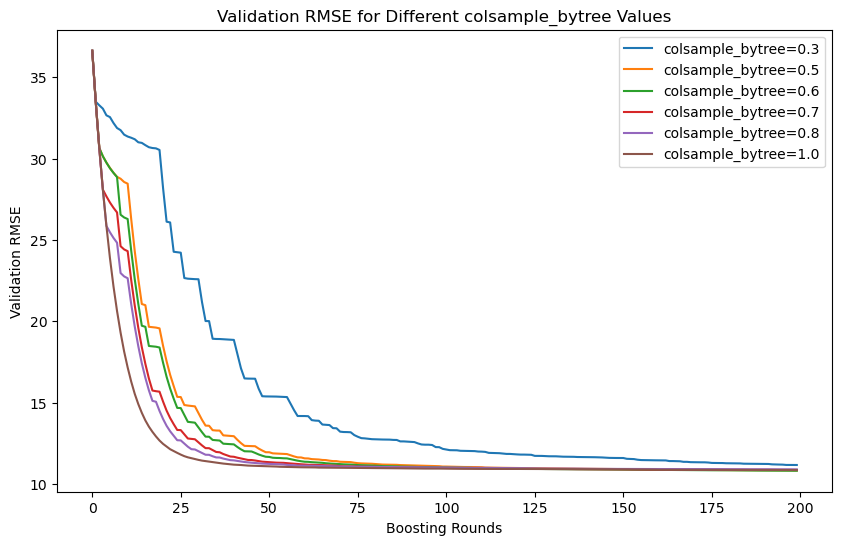

Final RMSE for colsample_bytree=0.3: 11.169699312673615
Final RMSE for colsample_bytree=0.5: 10.835563172455753
Final RMSE for colsample_bytree=0.6: 10.817615212904578
Final RMSE for colsample_bytree=0.7: 10.863519698556807
Final RMSE for colsample_bytree=0.8: 10.899511051700465
Final RMSE for colsample_bytree=1.0: 10.862593127921986


In [ ]:
# Define a function to train models with varying colsample_bytree
def train_xgboost_with_colsample_bytree(colsample_bytree, num_boost_round, gamma = 0.1, eta=0.1, max_depth=5,  min_child_weight=3, subsample=1, early_stopping_rounds=None):
    xgb_params = {
        'eta': eta,                      # Learning rate
        'max_depth': max_depth,          # Depth of trees
        'gamma': gamma,                  # Minimum loss reduction to split
        'subsample': subsample,          # Fraction of data for each tree
        'colsample_bytree': colsample_bytree,  # Fraction of features for each tree
        'min_child_weight': min_child_weight,  # Minimum sum of weights in child nodes
        'objective': 'reg:squarederror', # Regression objective
        'nthread': 8,                    # Number of threads
        'seed': 1,                       # Random seed
        'verbosity': 1,                  # Verbosity level
        'eval_metric': 'rmse'            # Metric for monitoring performance
    }

    evals_result = {}

    model = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=num_boost_round,
        evals=watchlist,
        verbose_eval=False,  # Suppress output during training
        early_stopping_rounds=early_stopping_rounds,
        evals_result=evals_result
    )
    
    return evals_result, model

# Test different colsample_bytree values
colsample_bytree_values = [0.3, 0.5, 0.6, 0.7, 0.8, 1.0]
results_colsample_bytree = {}

for colsample_bytree in colsample_bytree_values:
    evals_result, model = train_xgboost_with_colsample_bytree(colsample_bytree=colsample_bytree, num_boost_round=200)
    results_colsample_bytree[colsample_bytree] = evals_result

# Plot the RMSE for different colsample_bytree values
plt.figure(figsize=(10, 6))

for colsample_bytree, evals_result in results_colsample_bytree.items():
    val_rmse = evals_result['val']['rmse']
    plt.plot(range(len(val_rmse)), val_rmse, label=f'colsample_bytree={colsample_bytree}')

plt.xlabel('Boosting Rounds')
plt.ylabel('Validation RMSE')
plt.title('Validation RMSE for Different colsample_bytree Values')
plt.legend()
plt.show()

# Print final RMSE for each colsample_bytree value
for colsample_bytree, evals_result in results_colsample_bytree.items():
    print(f"Final RMSE for colsample_bytree={colsample_bytree}: {evals_result['val']['rmse'][-1]}")


In [ ]:
# final model
# Train the final model with optimal hyperparameters
xgb_params = {
    'eta': 0.1,                  # Learning rate
    'max_depth': 5,              # Depth of trees
    'gamma': 0.1,                # Minimum loss reduction to split
    'subsample': 1,              # Fraction of data for each tree
    'colsample_bytree': 0.6,     # Fraction of features for each tree
    'min_child_weight': 3,       # Minimum sum of weights in child nodes
    'objective': 'reg:squarederror',  # Regression objective
    'nthread': 8,                # Number of threads
    'seed': 1,                   # Random seed
    'verbosity': 1,              # Verbosity level
    'eval_metric': 'rmse'        # Metric for monitoring performance
}

In [ ]:
# final model
# Train the final model with optimal hyperparameters
xgb_params = {
    'eta': 0.1,                  # Learning rate
    'max_depth': 5,              # Depth of trees
    'gamma': 0.1,                # Minimum loss reduction to split
    'subsample': 1,              # Fraction of data for each tree
    'colsample_bytree': 0.6,     # Fraction of features for each tree
    'min_child_weight': 3,       # Minimum sum of weights in child nodes
    'objective': 'reg:squarederror',  # Regression objective
    'nthread': 8,                # Number of threads
    'seed': 1,                   # Random seed
    'verbosity': 1,              # Verbosity level
    'eval_metric': 'rmse'        # Metric for monitoring performance
}
# Train the final model

model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=200,  # Maximum boosting rounds
    evals=[(dtrain, 'train'), (dval, 'val')],  # Monitor train and validation RMSE
    verbose_eval=5,  # Print every 5 rounds
    early_stopping_rounds=10  # Stop if no improvement for 10 rounds
)

# Make predictions on the validation set
y_pred = model.predict(dval)

# Calculate RMSE
rmse = mean_squared_error(y_val, y_pred, squared=False)
print(f"Validation RMSE: {rmse}")


[0]	train-rmse:36.28157	val-rmse:36.63585


[5]	train-rmse:29.21205	val-rmse:29.40963
[10]	train-rmse:26.11193	val-rmse:26.29084
[15]	train-rmse:19.61820	val-rmse:19.66442
[20]	train-rmse:17.44658	val-rmse:17.45512
[25]	train-rmse:14.71873	val-rmse:14.66890
[30]	train-rmse:13.52819	val-rmse:13.47820
[35]	train-rmse:12.72352	val-rmse:12.68865
[40]	train-rmse:12.45354	val-rmse:12.43687
[45]	train-rmse:11.99357	val-rmse:12.00041
[50]	train-rmse:11.64138	val-rmse:11.66453
[55]	train-rmse:11.54297	val-rmse:11.57617
[60]	train-rmse:11.31226	val-rmse:11.37030
[65]	train-rmse:11.23131	val-rmse:11.30387
[70]	train-rmse:11.12169	val-rmse:11.22182
[75]	train-rmse:11.05270	val-rmse:11.16516
[80]	train-rmse:11.00212	val-rmse:11.12879
[85]	train-rmse:10.94658	val-rmse:11.09061
[90]	train-rmse:10.90795	val-rmse:11.06084
[95]	train-rmse:10.87525	val-rmse:11.04202
[100]	train-rmse:10.82918	val-rmse:11.01544
[105]	train-rmse:10.79447	val-rmse:10.99677
[110]	train-rmse:10.76139	val-rmse:10.96914
[115]	train-rmse:10.73513	val-rmse:10.95671
[120]	tr

/opt/anaconda3/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:

model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=150
)

# Make predictions on the validation set
y_pred = model.predict(dval)

# Calculate RMSE
rmse = mean_squared_error(y_val, y_pred, squared=False)
print(f"Final Validation RMSE: {rmse}")


Final Validation RMSE: 10.885143898417782


/opt/anaconda3/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
